## Install packages 

In [1]:
#%pip install vaderSentiment --quiet
%pip install unidecode spacy --quiet
%python -m spacy download es_core_news_sm --quiet
#%pip install textblob --quiet
%pip install plotly nltk --quiet
%pip install chardet --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [2]:
#Text transformation
from unidecode import unidecode
import unicodedata
from dateutil import parser
from datetime import datetime
import pickle,nltk,re,os, pandas as pd, numpy as np
from pandas import DataFrame, merge, concat
from tqdm import tqdm
tqdm.pandas()

#Tokenize 
#for text pre-processing
import re,string,os,nltk,ssl,spacy
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords','punkt','averaged_perceptron_tagger','wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
#from nltk.stem import SnowballStemmer, WordNetLemmatizer
#from nltk.stem.snowball import SpanishStemmer


#for word embedding
import gensim
from gensim.models import Word2Vec

%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', 150)

## Remove unnecessary words in date and title


In [3]:
#Preprocessing the whole dataframe
class DataProcessor:
    def __init__(self, data):
        self.data = data
        self.stop_words = set(stopwords.words('spanish'))
        self.month_mapping = {
            'enero': '01', 'febrero': '02', 'marzo': '03', 'abril': '04',
            'mayo': '05', 'junio': '06', 'julio': '07', 'agosto': '08',
            'septiembre': '09', 'octubre': '10', 'noviembre': '11', 'diciembre': '12',
            'january': '01', 'february': '02', 'march': '03', 'april': '04',
            'may': '05', 'june': '06', 'july': '07', 'august': '08',
            'september': '09', 'october': '10', 'november': '11', 'december': '12'
            }
        
    #function for time cleaning
    def remove_words(self, text):
        if pd.notnull(text) and isinstance(text, str):  
            words = text.split()
            filtered_words = [word for word in words if word.lower() not in self.stop_words]
            return ' '.join(filtered_words)
        else:
            return text

    # Function to remove extra spaces and keep single space
    def clean_spaces(self, text):
        text = text.lower()
        words = text.split()
        # Remove the first word using list slicing
        words = words[1:]
        words = text.replace(',', '').split()
        # Join the words with a single space between them
        cleaned_text = " ".join(words)
        # Remove commas using regular expression
        cleaned_text = re.sub(r',', '', cleaned_text)
        cleaned_text = unidecode(cleaned_text)
        return cleaned_text

    def custom_parser(self, date_string):
        date_string = ' '.join([word for word in date_string.split() if word.lower() not in self.stop_words])
    
        # Remove stopwords and unwanted characters from the date string
        date_string = re.sub(r'(y quintana roo|y san diego|zurich|winnipeg canadá|y chicago)', '', date_string, flags=re.IGNORECASE)  # Remove 'y quintana roo'
        date_string = re.sub(r'(y moscú|zúrich suiza)', '', date_string, flags=re.IGNORECASE)  # Remove 'y quintana roo'
        date_string = re.sub(r'y quintana roo', '', date_string, flags=re.IGNORECASE)  # Remove 'y quintana roo'
        date_string = re.sub(r'(jueves|lunes|martes|miercoles|viernes|sabado|domingo)', '', date_string, flags=re.IGNORECASE)  # Remove 'jueves'
        date_string = re.sub(r'[|].*$', '', date_string)  # Remove '| 19:27 pm hrs'
        
        # Remove any word before the digits (e.g., 'septiembre 11 2019' from 'septiembre 11 2019 | 19:27 pm hrs')
        date_string = re.sub(r'^[a-zA-Z]+\s+(\d{1,2})\s+(\d{4})$', r'\1-\2', date_string)
        
        # Remove any word before the digits (e.g., 'septiembre 11 2019' becomes '11 septiembre 2019')
        date_string = re.sub(r'^\D*(\d{1,2})\s+(\w+)\s+(\d{4})$', r'\1 \2 \3', date_string)
        date_string = ' '.join([word for word in date_string.split() if word.lower() not in self.stop_words])
        
        # Remove any word before the digits (e.g., 'viena 12.03.2021' becomes '12.03.2021')
        date_string = re.sub(r'^\D*(\d{1,2}\.\d{2,2}\.\d{4,4})$', r'\1', date_string)

        # Check if the date is in the format 'month day year' (e.g., 'june 25 2010')
        try:
            parsed_date = datetime.strptime(date_string, '%B %d %Y')
            return parsed_date.strftime('%d-%m-%Y')
        except ValueError:
            pass
            
        # Check if the date matches the format 'Month day, year at time am/pm timezone'
        try:
            formatted_date = datetime.strptime(date_string, '%B %d, %Y at %I:%M %p %Z')
            return formatted_date
        except ValueError:
            pass

        # Check if the date contains day, month, year, and time (e.g., 'february 27 2017 at 5:00 am est')
        if re.match(r'[a-zA-Z]+\s+\d{1,2}\s+\d{4}\s+at\s+\d{1,2}:\d{2}\s+(am|pm)', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+|am|pm', date_string.lower())
            month = self.month_mapping.get(parts[0].lower(), '01')
            day = parts[1].zfill(2)
            year = parts[2]
            hour = parts[4] if parts[4] != '12' else '00'
            minute = parts[5]
            meridian = parts[6]
            
            # Convert 12-hour time to 24-hour format
            if meridian == 'pm':
                hour = str(int(hour) + 12).zfill(2)
            
            try:
                return parser.parse(f'{day}-{month}-{year} {hour}:{minute}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
        
        # Check if the date contains day, month, and year (e.g., 'june 22 2010')
        elif re.match(r'[a-zA-Z]+\s+\d{1,2}\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            month = self.month_mapping.get(parts[0].lower(), '01')
            day = parts[1].zfill(2)
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
            
        # Check if the date is in the format 'september 22 2023'
        elif re.match(r'[a-zA-Z]+\s+\d{1,2}\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            month = self.month_mapping.get(parts[0].lower(), '01')
            day = parts[1].zfill(2)
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
            
        # Check if the date contains day, month, and year (e.g., 'septiembre 11 2019')
        elif re.match(r'[a-zA-Z]+\s+\d{1,2}\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            month = self.month_mapping.get(parts[0].lower(), '01')
            day = parts[1].zfill(2)
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
            
        # Check if the date contains day, month, and year in the format '03.11.2019'
        elif re.match(r'\d{2}.\d{2}.\d{4}', date_string):
            parts = re.findall(r'\d+', date_string)
            day = parts[0].zfill(2)
            month = parts[1].zfill(2)
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
        
        # Check if the date contains day and month (e.g., '11 septiembre 2019')
        elif re.match(r'\d{1,2}\s+[a-zA-Z]+\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            day = parts[0].zfill(2)
            month = self.month_mapping.get(parts[1].lower(), '01')
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
            
        elif re.match(r'[a-zA-Z]+\s+\d{1,2},\s+\d{4}\s+at\s+\d{1,2}:\d{2}\s+[apm]+\s+[a-zA-Z]+', date_string):
            parts = re.findall(r'[a-zA-Z]+|\d+', date_string)
            month = self.month_mapping.get(parts[0].lower(), '01')
            day = parts[1].zfill(2)
            year = parts[2]
            hour = parts[4].zfill(2)
            minute = parts[5]
            am_pm = parts[6].lower()
            if am_pm == 'pm':
                hour = str(int(hour) + 12)  # convert to 24-hour format
            try:
                return parser.parse(f'{day}-{month}-{year} {hour}:{minute}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Check if the date contains month and year (e.g., 'septiembre 2023')
        elif re.match(r'[a-zA-Z]+\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            month = self.month_mapping.get(parts[0].lower(), '01')
            year = parts[1]
            try:
                return parser.parse(f'01-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Check if the date is in the format '30072020'
        elif re.match(r'\d{8}', date_string):
            day = date_string[0:2]
            month = date_string[2:4]
            year = date_string[4:8]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Check if the date contains month name, day, year, and time (e.g., 'february 27, 2017 at 5:00 am est')
        elif re.match(r'[a-zA-Z]+\s+\d{1,2},\s+\d{4}\s+at\s+\d{1,2}:\d{2}\s+[apm]+\s+[a-zA-Z]+', date_string):
            try:
                return parser.parse(date_string, dayfirst=False)
            except (TypeError, ValueError):
                return pd.NaT


        # Check if the date contains day, month, and year (e.g., '04 octubre 2023 fecha publicación')
        elif re.match(r'\d{1,2}\s+[a-zA-Z]+\s+\d{4}\s+fecha\s+publicación', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            day = parts[0].zfill(2)
            month = self.month_mapping.get(parts[1].lower(), '01')
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Check if the date contains day, month abbreviation, and year (e.g., '30 ene. 2017')
        elif re.match(r'\d{1,2}\s+[a-zA-Z]+\.\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            day = parts[0].zfill(2)
            month = self.month_mapping.get(parts[1].lower(), '01')
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Check if the date contains day, month, year, and a specific phrase (e.g., '04 octubre 2023 fecha publicación')
        elif re.match(r'\d{1,2}\s+[a-zA-Z]+\s+\d{4}\s+[a-zA-Z\s]+', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            day = parts[0].zfill(2)
            month = self.month_mapping.get(parts[1].lower(), '01')
            year = parts[2]
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
            
        # Check if the date contains month and year (e.g., 'septiembre 2019')
        elif re.match(r'[a-zA-Z]+\s+\d{4}', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            month = self.month_mapping.get(parts[0].lower(), '01')
            year = parts[1]
            try:
                return parser.parse(f'01-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
        
        # Check if the date contains day, month, year, and a specific phrase (e.g., 'miercoles 11 octubre 2017 - 14:07:')
        elif re.match(r'[a-zA-Z]+\s+\d{1,2}\s+[a-zA-Z]+\s+\d{4}\s+-\s+\d{2}:\d{2}:', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            day = parts[1].zfill(2)
            month = self.month_mapping.get(parts[2].lower(), '01')
            year = parts[3]
            time = re.search(r'(\d{2}:\d{2})', date_string).group(1)
            try:
                return parser.parse(f'{day}-{month}-{year} {time}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Check if the date contains day, month, year, and time in the format 'miercoles 11 octubre 2017 - 14:07:'
        elif re.match(r'^[a-zA-Z]+\s+\d{1,2}\s+[a-zA-Z]+\s+\d{4}\s+-\s+\d{2}:\d{2}:', date_string):
            parts = re.findall(r'\d+|[a-zA-Z]+', date_string)
            day = parts[1].zfill(2)
            month = self.month_mapping.get(parts[2].lower(), '01')
            year = parts[3]
            time = re.search(r'(\d{2}:\d{2})', date_string).group(1)
            try:
                return parser.parse(f'{day}-{month}-{year} {time}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT
       
        # Check if the date is in the format 'edición 05102023'
        elif re.match(r'edición\s+(\d{2})(\d{2})(\d{4})', date_string):
            match = re.match(r'edición\s+(\d{2})(\d{2})(\d{4})', date_string)
            day = match.group(1).zfill(2)
            month = match.group(2).zfill(2)
            year = match.group(3)
            try:
                return parser.parse(f'{day}-{month}-{year}', dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

        # Handle other date formats using the initial logic
        else:
            # Remove '- 00:06' pattern
            date_string = re.sub(r'-\s\d{2}:\d{2}$', '', date_string)
            date_string = re.sub(r'\s\d{2}:\d{2}$', '', date_string)
            try:
                return parser.parse(date_string, dayfirst=True)
            except (TypeError, ValueError):
                return pd.NaT

    def extract_word_between_slashes(self, url):
        pattern = r"/([^/]+)/"
        matches = re.findall(pattern, url)
        if matches:
            return matches
        else:
            return None

    def extract_word_after_com_mx(self, url):
        pattern = r"\.com\.mx/([^/]+)/"
        match = re.search(pattern, url)
        if match:
            return match.group(1)
        else:
            return None

    def extract_digits_between_hyphens(self, url):
        pattern = r"-(\d+)-"
        match = re.search(pattern, url)
        if match:
            return match.group(1)
        else:
            return None

    def parse_date(self, date_string):
        formats = [
            '%A %d de %B de %Y - %H:%M',
            '- %d %b, %Y',
            '/ %d.%m.%Y %H:%M:%S',
            '| %d-%m-%Y'
        ]
        for fmt in formats:
            try:
                return pd.to_datetime(date_string, format=fmt).strftime('%Y-%m-%d')
            except ValueError:
                pass
        return None

    def extract_word(self, url):
        pattern = r"//(.*?)\.com"
        match = re.search(pattern, url)
        if match:
            return match.group(1)
        else:
            return None

    def remove_accents(self, text):
        if isinstance(text, str):
            return ''.join(char.lower() for char in unicodedata.normalize('NFD', text) if unicodedata.category(char) != 'Mn')
        return ''  # Return empty string for NaN values

    def remove_stopwords(self, text):
        if pd.notnull(text) and isinstance(text, str):  # Check for NaN values
            words = text.split()
            filtered_words = [word for word in words if word.lower() not in self.stop_words]
            return ' '.join(filtered_words)
        else:
            return text
        
    def process_data(self):
        # Apply transformations to self.data using class methods
        try:
            self.data['time'] = self.data['time'].progress_apply(lambda x: self.remove_words(x.lower()))
            # Remove first words and special characters from 'dates' column
            self.data['time'] = (self.data['time']
                        .str.lower()
                        .str.replace(r'^(washington|martes|-|/|\|)\s*', '', regex=True)
                        .str.replace(r'(de)', '', regex=True)
                        .str.replace(r'.*/\s*', '', regex=True)
                        .str.replace(r'\b\d{2}:\d{2}:\d{2}\b', '', regex=True)
                        .str.replace("'", '')
                        .str.strip()
                        )
            self.data['time'] = (self.data['time'].progress_apply(self.clean_spaces))
        except Exception as e:
            return self.data['time']
        self.data['date'] = self.data['time'].progress_apply(self.custom_parser)
        self.data['month'] = pd.PeriodIndex(self.data.date, freq='M')
        self.data['topics_link'] = self.data['link'].progress_apply(self.extract_word_after_com_mx)
        #self.data.loc[pd.isnull(self.data.newspaper),'newspaper'] = self.data[pd.isnull(self.data.newspaper)]['link'].progress_apply(self.extract_word)
        #self.data['title']= (self.data['title'].progress_apply(lambda x: self.remove_stopwords(self.remove_accents(x))))
        self.data['content'] = self.data['content'].progress_apply(lambda x: self.remove_stopwords(self.remove_accents(x)))

def extract_ymd(df, column_name):
    """
    Extracts year, month, and day from a datetime column in a DataFrame.

    :param df: DataFrame containing the datetime column.
    :param column_name: Name of the column with datetime strings.
    :return: DataFrame with the formatted dates.
    """
    # Convert the column to datetime objects, unparseable dates become NaT
    df[column_name] = pd.to_datetime(df[column_name], errors='coerce')

    # Only format the cells that were successfully converted to datetime
    df.loc[df[column_name].notnull(), column_name] = df.loc[df[column_name].notnull(), column_name].dt.strftime('%Y-%m-%d')

    return df

# Preprocessing 


## Read data

In [4]:
class TextPreprocessor:
    def __init__(self):
        self.nlp = spacy.load("es_core_news_sm")
        #self.spanish_stemmer = SnowballStemmer("spanish")
        self.english_spanish_stopwords = set(stopwords.words('english')) | set(stopwords.words('spanish'))
        self.spanish = ['y','el','del','lo','la']
        self.english_spanish_stopwords.update(self.spanish)
        
    @staticmethod
    def remove_brackets(lst):
        if pd.notnull(lst) and isinstance(lst, str):  
            return ', '.join(map(str, lst))
    
    @staticmethod
    def preprocess(text):
        if isinstance(text, str):  
            text = text.lower()
            text = re.sub(r'\[[0-9]*\]',' ',text)
            text = re.sub(r'\d',' ',text)
            text = re.sub('\s+', ' ', text) #remove all whitespace
            text = re.sub(r'\s+',' ',text) #remove all whitespace including backslash
            text = re.sub(r'[^\w\s.]', ' ', str(text)) #remove all non-alphanumeric and non-whitespace characters from a given text string.
            text = re.sub('[%s]' % re.escape(''.join(c for c in string.punctuation if c != '.')), ' ', text)
            #text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
            text = re.compile('<.*?>').sub('', text) #Remove HTML tags
            text = unidecode(text)
            text = text.strip()
            text = re.sub('\s+', ' ', text) #remove all whitespace
            text = re.sub(r'\s+',' ',text) #remove all whitespace including backslash
        return text
    
    def lemmatizer(self, string):
        if isinstance(string, str): 
            doc = self.nlp(string)
            lemmatized_words = [token.lemma_ for token in doc]
            return " ".join(lemmatized_words)
        
    def stopword(self, text):
        if isinstance(text, str):
            words = text.split()
            filtered_words = [word for word in words if word not in self.english_spanish_stopwords]
            return ' '.join(filtered_words)
        elif isinstance(text, pd.Series):
            return text.apply(self.stopword)  # Apply stopword method to each element in the Series
        else:
            return text
    
    #Before
    #def tokenizer(self, string):
    #    if isinstance(string, str):  
    #        word_pos_tags = nltk.pos_tag(word_tokenize(string))
    #        a = [self.lemmatizer(tag[0], self.get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    #        return " ".join(a)
    
    def tokenizer(self, string):
        if isinstance(string, str):  
            doc = self.nlp(string)
            lemmatized_words = [token.lemma_ for token in doc]
            return " ".join(lemmatized_words)
        
    def get_wordnet_pos(self, tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    def finalpreprocess(self, texts):
        processed_texts = []
        for text in tqdm(texts, desc="Processing texts", ncols=100):
            processed_text = self.preprocess(self.stopword(text))
            processed_texts.append(processed_text)
        return processed_texts


In [5]:
## Remove sentences with keywords
def remove_sentences_with_keywords(text, keywords):
    """
    Removes sentences that contain any of the specified keywords.

    :param text: The original text.
    :param keywords: A list of keywords to check for in each sentence.
    :return: The text with the specified sentences removed.
    """
    # Split text into sentences
    keywords = ["copyright", "derechos", 'newsletter', 'pagina','ciudad de mexico']
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    # Filter out sentences that contain any of the keywords
    filtered_sentences = [sentence for sentence in sentences if not any(keyword in sentence for keyword in keywords)]

    # Combine the remaining sentences back into a single string
    return filtered_sentences


# # Example DataFrame
# def select_sentences(text):
#     my_list = ["inflacion","interes","presiones inflacionarias","actividad economica", 
#            "empleo","precios","fondo inversion","inversion","ied","recesion",
#            'desempleo','tipo cambio','crecimiento','productividad','oferta', 
#            'deficit', 'demanda', 'mercado laboral','politica monetaria','consumidores']
#     words = '|'.join("Inflación inflacion precios precio productos consumo ".split())
#     keywords = my_list + words.split('|')
#     sentences = nltk.sent_tokenize(text)
#     selected_sentences = []
#     for sentence in sentences:
#         words = sentence.split()
#         if len(words) > 15 or any(keyword.lower() in sentence.lower() for keyword in keywords):
#             selected_sentences.append(sentence)
#         if len(selected_sentences) == 5:
#             break
#     return ' '.join(selected_sentences)


def select_sentences(text):
    my_list = ["inflacion","interes","presiones inflacionarias","actividad economica", 
        "empleo","precios","fondo inversion","inversion","ied","recesion",
        'desempleo','tipo cambio','crecimiento','productividad','oferta', 
        'deficit', 'demanda', 'mercado laboral','politica monetaria','consumidores']
    words = '|'.join("Inflación inflacion precios precio productos consumo ".split())
    keywords = my_list + words.split('|')

    sentences = nltk.sent_tokenize(text)
    selected_sentences = []
    
    for sentence in sentences:
        if any(keyword.lower() in sentence.lower() for keyword in keywords) and len(sentence.split()) > 10:
            selected_sentences.append(sentence)
        if len(selected_sentences) == 5:
            break

    # Fill the remaining slots with '.' if there are less than 5 sentences
    while len(selected_sentences) < 5:
        selected_sentences.append('.')

    return ' '.join(selected_sentences)

## Read data and process text

In [6]:
## Quitar todas las filas que no tienen contenido
#df = df[(df.time.str.strip().astype(bool)) & (df.content.str.strip().astype(bool))]
df = pd.read_pickle('../scrap_data/final.pkl')
df = df[~df.content.str.contains('El error|Lo sentimos pero|Lamentamos las')]

#remove sentences with keywords
keywords = ["copyright", "derechos", 'newsletter', 'pagina','ciudad de mexico']
df['content'] = df['content'].progress_apply(lambda x: ' '.join(remove_sentences_with_keywords(unidecode(x).lower(),keywords)))

## Quedar con filas que tienen observaciones
df = df[df['content'].str.strip().astype(bool)]
df = extract_ymd(df, 'time')

# Apply sentence tokenization to the 'text' column and keep only the first 3 sentences
print("-------------------------------------------------","\n")
df['content'] = df['content'].progress_apply(select_sentences)#.progress_apply(lambda x: ' '.join(nltk.sent_tokenize(x)[:5]))
print("-------------------------------------------------","\n")
print('preprocess dataset')
DataProcessor(df).process_data() ##Preprocessing the whole dataframe
print("-------------------------------------------------","\n")
print('preprocess text for analysis:','\n')
df['content'] = TextPreprocessor().finalpreprocess(df.content)

100%|██████████| 73784/73784 [00:02<00:00, 26373.46it/s]


------------------------------------------------- 



100%|██████████| 73784/73784 [00:07<00:00, 10395.62it/s]


------------------------------------------------- 

preprocess dataset


  0%|          | 1/73784 [00:00<28:59, 42.42it/s]


------------------------------------------------- 

preprocess text for analysis: 



Processing texts: 100%|████████████████████████████████████| 73784/73784 [00:05<00:00, 12461.79it/s]


In [7]:
# @Explode column ``content`` into sentences
df['text'] = df['content'].apply(lambda x: ' '.join(sent_tokenize(x)))
#df = df.explode('text')

In [8]:
df['word_length'] = [len(word_tokenize(word)) for word in df['text']]

In [9]:
df.word_length.value_counts().sort_index()

word_length
5        14312
13           7
14          20
15         396
16         615
         ...  
263          1
463          1
494          1
4063         1
15479        1
Name: count, Length: 189, dtype: int64

In [10]:
df.word_length.describe()

count    73784.000000
mean        52.642212
std         69.178362
min          5.000000
25%         21.000000
50%         49.000000
75%         80.000000
max      15479.000000
Name: word_length, dtype: float64

In [11]:
# @Remove punctuacion
def punctuacion(text):
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
  return text

df['text'] = df['text'].progress_apply(punctuacion)

  0%|          | 0/73784 [00:00<?, ?it/s]

100%|██████████| 73784/73784 [00:00<00:00, 85338.61it/s] 


In [12]:
# Define minimum and maximum word count
min_words = 4
max_words = 600

# Create a boolean mask
mask = df['text'].progress_apply(lambda x: min_words <= len(word_tokenize(x)) <= max_words)

# Filter the DataFrame
df = df[mask]

del mask

100%|██████████| 73784/73784 [00:12<00:00, 5737.28it/s]


In [370]:
len(df)

59470

In [ ]:
df = df.drop_duplicates()

In [13]:
english_spanish_stopwords = set(stopwords.words('english')) | set(stopwords.words('spanish'))
spanish = ['y','el','del','lo','la']
english_spanish_stopwords.update(spanish)
df['text'] = df['text'].apply(unidecode)
df.text = [words for words in df.text if words not in english_spanish_stopwords ]

In [14]:
df.sample(2)

,title,content,time,newspaper,link,text,word_length
15008,Muestra desempleo profunda recesión.- EU,cabe duda largo camino recorrer volver poner funcionamiento economia numeros empleo recordatorio mas dijo portavoz casa blanca robert gibbs prensa...,2009-03-06,El Reforma,http://biblioteca.iiec.unam.mx/index.php?option=com_content&task=view&id=4412&Itemid=146,cabe duda largo camino recorrer volver poner funcionamiento economia numeros empleo recordatorio mas dijo portavoz casa blanca robert gibbs prensa...,67
47519,"Acaparamiento de vacunas profundizará desigualdad, estima FMI",ejemplo solo economias g excluidas india arabia saudita debido limitaciones datos perdidas totales empleo proyectan mas millones ano cerca millone...,2021-02-24,jornada,https://www.jornada.com.mx/notas/2021/02/24/economia/acaparamiento-de-vacunas-profundizara-desigualdad-estima-fmi/,ejemplo solo economias g excluidas india arabia saudita debido limitaciones datos perdidas totales empleo proyectan mas millones ano cerca millone...,52


# @Word count


## Datos de inflacion

In [15]:
my_list = ["inflacion","interes", "presiones inflacionarias","actividad economica", 
           "empleo","precios","fondo inversion","inversion","ied","recesion",
           'desempleo','tipo cambio','crecimiento','productividad','oferta', 
           'deficit', 'demanda', 'mercado laboral','politica monetaria','consumidores']
words = '|'.join("Inflación inflacion precios precio productos consumo ".split())
concept = my_list + words.split('|')

# Assuming df is your DataFrame and 'content' is the column you want to filter
df['text_column'] = df['text'].apply(lambda x: next((word for word in concept if word.lower() in unidecode(x).lower()), None))

#Extract year, month, and day into separate columns
df['time'] = pd.to_datetime(df['time'], errors='coerce')

df['year'] = (df['time'].dt.year).fillna(-1).astype(int)
df['month'] = (df['time'].dt.month).fillna(-1).astype(int)
df['day'] = (df['time'].dt.day).fillna(-1).astype(int)

inflacion = df[df['text'].str.contains('|'.join(map(re.escape, concept)), case=False, regex=True)].sort_values(by='time', ascending=False)
inflacion['month'] = inflacion['month'].astype(str)
inflacion = inflacion[~inflacion['time'].isna()]
print('Total observacion: ',len(inflacion))

Total observacion:  38212


In [16]:
import chardet
## Open CPI data
with open('../data/Indicadores20231111182822.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
encoding = result['encoding']
inflacion_dt = pd.read_csv('../data/Indicadores20231111182822.csv', 
                           encoding=encoding, skiprows=4)

cols = {'Periodos':'date','583753':'cpi'}
inflacion_dt = inflacion_dt.rename(columns=cols)
inflacion_dt['month'] = pd.PeriodIndex(inflacion_dt.date, freq='M')#.astype(str).str.replace('Q','-')#pd.to_datetime(inflacion_dt['time']).dt.strftime('%Y-%m')

inflacion_dt['date'] = inflacion_dt['date'].str.replace('/','-', regex=True)

#classification of labels
def categorize(col):
  if col > 0:
    return 'negativo'
  elif col < 0:
    return 'positivo'
  else:
    return 'neutro'
  

inflacion_dt['tx_cpi'] = inflacion_dt.cpi.pct_change(1).fillna(0)
inflacion_dt['label'] = inflacion_dt['tx_cpi'].apply(lambda x: categorize(x))

In [17]:
inflacion['month'] = pd.PeriodIndex(inflacion.time, freq='M')
inflacion = pd.merge(inflacion_dt, inflacion, on='month')

In [18]:
inflacion.sample(2)

,date,cpi,month,tx_cpi,label,title,content,time,newspaper,link,text,word_length,text_column,year,day
14490,2021-02,3.76,2021-02,0.062147,negativo,Disminuye en enero de grado de bienestar de población urbana: Inegi,mexico deficit comercial mil mdd enero inegi subsecretario hospital temporal citi banamex pasado miercoles recibe tratamiento covid tambien pronos...,2021-02-26,jornada,https://www.jornada.com.mx/notas/2021/02/26/economia/inegi-grado-de-bienestar-en-pobladores-con-ligero-retroceso-en-enero/,mexico deficit comercial mil mdd enero inegi subsecretario hospital temporal citi banamex pasado miercoles recibe tratamiento covid tambien pronos...,33,deficit,2021,26
12466,2017-03,5.35,2017-03,0.100823,negativo,Cae desempleo en México a su menor nivel desde 2006,baja tasa desempleo resultado mejora parte sector externo afirmo james salazar subdirector analisis economico ci banco. visto ultimos meses partic...,2017-03-29,El Financiero,http://biblioteca.iiec.unam.mx/index.php?option=com_content&task=view&id=25069&Itemid=146,baja tasa desempleo resultado mejora parte sector externo afirmo james salazar subdirector analisis economico ci banco visto ultimos meses partic...,48,empleo,2017,29


In [19]:
inflacion.month.value_counts().describe()

count     183.000000
mean      203.196721
std       454.180974
min         2.000000
25%        46.000000
50%        82.000000
75%       183.000000
max      4396.000000
Name: count, dtype: float64

<Axes: xlabel='time'>

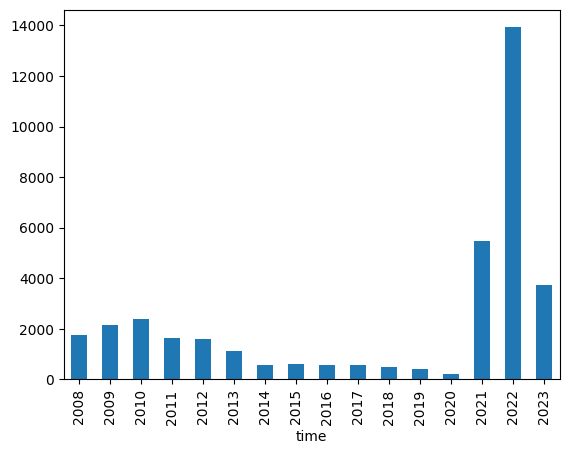

In [20]:
inflacion.time.dt.year.value_counts().sort_index().plot(kind='bar')

In [488]:
inflacion['Quarter'] = pd.PeriodIndex(inflacion.month, freq='Q').astype(str)

# Load the new version of the data from the uploaded CSV file
file_path_new = '../data/PIB.csv'
try:
    pib = pd.read_csv(file_path_new)
except UnicodeDecodeError:
    # If there's a UnicodeDecodeError, try a different encoding
    pib = pd.read_csv(file_path_new, encoding='latin1')

# Mapping quarters to their respective month numbers
quarter_to_month = {'I': '1', 'II': '2', 'III': '3', 'IV': '4'}
pib['quarter_month'] = pib['year'].astype(str) + 'Q' + pib['qter'].map(quarter_to_month)

# Display the first few rows to verify the transformation
pib.head()


inflacion = pd.merge(inflacion, pib[['quarter_month','tx_pib_cr']],
         left_on='Quarter', right_on='quarter_month')

# Plotting
inflacion['Quarter'].value_counts().sort_index().plot(kind='bar', figsize=(10, 4));

In [21]:
inflacion.pivot_table(index=['time','cpi'], columns='text_column', aggfunc='size', fill_value=0)

,text_column,actividad economica,consumidores,consumo,crecimiento,deficit,demanda,empleo,fondo inversion,ied,inflacion,...,inversion,mercado laboral,oferta,politica monetaria,precio,precios,productividad,productos,recesion,tipo cambio
time,cpi,,,,,,,,,,,,,,,,,,,,,
2008-01-07,3.70,0,0,0,0,0,1,0,0,0,1,...,2,0,0,0,0,0,0,0,0,0
2008-01-08,3.70,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2008-01-09,3.70,0,0,0,2,0,0,2,0,0,1,...,1,0,0,0,0,3,0,0,0,0
2008-01-10,3.70,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2008-01-14,3.70,0,0,0,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10,4.45,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
2023-09-11,4.45,0,0,0,4,0,0,9,0,0,5,...,5,0,0,0,0,0,0,0,0,0
2023-09-12,4.45,0,0,0,0,0,0,0,0,0,9,...,5,0,0,0,0,5,0,0,0,0


In [490]:
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dateutil

# Pivot the DataFrame
# Convert Period objects to string representation
inflacion['month'] = inflacion['month'].astype(str)
pivot_table = inflacion.pivot_table(index='month', columns='text_column', aggfunc='size', fill_value=0)

# Create subplots
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=[''])

# Add traces for each quarter
for column in pivot_table.columns:
    trace = go.Scatter(x=pivot_table.index, y=pivot_table[column], mode='lines+markers', name=column)
    fig.add_trace(trace, row=1, col=1)

# Update layout
fig.update_layout(title_text='Line Plot of Counts for each Quarter in concept_column',
                  xaxis_title='Concept Column',
                  yaxis_title='Count')

# Show the plot
fig.show()

In [491]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming you have the 'inflacion' DataFrame with 'concept_column' and 'month' columns
# You may replace 'inflacion' with your actual DataFrame name

# Convert Period objects to string representation
inflacion['month_str'] = inflacion['month'].astype(str)

# Get unique concepts
unique_concepts = inflacion['text_column'].unique()

# Create subplots
fig = make_subplots(rows=len(unique_concepts), cols=1, shared_xaxes=True, subplot_titles=unique_concepts)

# Iterate through each concept
for i, concept in enumerate(unique_concepts, start=1):
    # Filter DataFrame for the current concept
    concept_data = inflacion[inflacion['text_column'] == concept]
    
    # Pivot the filtered DataFrame
    pivot_table = concept_data.pivot_table(index='month_str', aggfunc='size', fill_value=0)
    
    # Add trace for the concept
    trace = go.Scatter(x=pivot_table.index, y=pivot_table, mode='lines+markers', name=concept)
    fig.add_trace(trace, row=i, col=1)

    # Update layout for each subplot
    fig.update_layout(title_text=f'Line Plot of Counts for {concept}',
                      xaxis_title='Quarter',
                      yaxis_title='Count',
                      showlegend=True)

# Update layout for the entire figure
fig.update_layout(height=len(unique_concepts) * 300, title_text='Line Plots for Each Concept')

# Show the plot
fig.show()

## Calculate word length

In [22]:
inflacion['word_len'] = [len(word_tokenize(word)) for word in inflacion['content']]

In [23]:
inflacion.word_len.describe()

count    37185.000000
mean        59.400645
std         31.092642
min         13.000000
25%         33.000000
50%         55.000000
75%         80.000000
max        463.000000
Name: word_len, dtype: float64

# Load dictionary

In [25]:
# Original string
word_sequence = """abalanzar	0	bautizar	0	desafiar	0	entrever	0	interceptar	0	prevenir	0	
sacar	0 abanderar	0	beber	0	desafinar	0	entrevistar	0	interconectar	0	prever	0	saciar	0
abandonar	-1	bendecir	0	desaforar	0	entristecer	0	interesar	0	primar	0	sacrificar	0
abaratar	0	beneficiar	1	desagradar	0	entrometer	0	interferir	0	priorizar	0	sacudir	0
abarcar	0	besar	0	desagregar	0	entronizar	0	intermediar	0	privar	0	saldar	0
abastecer	0	bitar	0	desahogar	0	enturbiar	0	internacionalizar	0	privatizar	0	salir	0
abatir	0	blandir	0	desahuciar	0	entusiasmar	1	internalizar	0	privilegiar	0	salpicar	0
abdicar	0	blanquear	0	desalentar	-1	enumerar	0	internar	0	probar	0	saltar	0
ablandar	0	blindar	0	desalinear	-1	enunciar	0	interpelar	0	proceder	0	saludar	0
abocar	0	bloquear	-1	desalinizar	0	envalentonar	0	interponer	0	procesar	0	salvaguardar	0
abogar	0	blumar	0	desalojar	0	envasar	0	interpretar	0	proclamar	0	salvar	1
abolir	0	boicotear	-1	desanclar	0	envejecer	0	interrogar	0	procrear	0	sanar	1
abonar	0	bombardear	0	desangrar	0	envenenar	0	interrumpir	0	procurar	0	sancionar	-1
abordar	0	bombear	0	desanimar	0	enviar	0	intervenir	0	prodigar	0	sanear	1
aborrecer	0	bonificar	0	desaparecer	-1	envidiar	0	intimidar	-1	producir	0	sangrar	0
abortar	0	bordar	0	desaprobar	0	enviudar	0	intoxicar	0	proferir	0	saquear	0
abrazar	0	bordear	0	desaprovechar	0	envolver	0	introducir	0	profesar	0	satisfacer	0
abreviar	0	borrar	0	desarmar	0	equilibrar	0	intuir	0	profesionalizar	0	saturar	0
abrigar	0	botar	0	desarrollar	0	equipar	0	inundar	0	profundizar	0	secar	0
abrir	0	bregar	0	desarticular	0	equiparar	0	inutilizar	0	programar	0	secuenciar	0
abrochar	0	brillar	0	desatar	0	equivaler	0	invadir	-1	progresar	0	secuestrar	0
abrumar	0	brindar	0	desatender	-1	equivocar	0	invalidar	0	prohibir	-1	secundar	0
absolver	0	bromear	0	desautorizar	0	erguir	0	inventar	0	proliferar	0	sedar	0
absorber	0	brotar	0	desayunar	0	erigir	0	invertir	1	prolongar	0	seducir	0
abstener	0	bucear	0	desbancar	0	erogar	0	investigar	0	promediar	0	segmentar	0
abuchear	0	burlar	0	desbandar	0	erosionar	-1	investir	0	prometer	0	segregar	0
abultar	0	buscar	0	desbaratar	0	erradicar	0	invisibilizar	0	promocionar	0	seguir	0
abundar	0	cabalgar	0	desbloquear	0	errar	-1	invitar	0	promover	0	seleccionar	0
aburrir	0	caber	0	desbocar	0	esbozar	0	invocar	0	promulgar	0	sellar	0
abusar	-1	cachar	0	desbordar	0	escabullir	0	involucrar	0	pronosticar	0	sembrar	0
acabar	0	caducar	0	descabezar	0	escalar	0	inyectar	0	pronunciar	0	sensibilizar	0
acallar	0	caer	-1	descalificar	-1	escandalizar	0	ir	0	propagar	0	sentar	0
acampar	0	cagar	0	descansar	0	escanear	0	ironizar	0	propender	0	sentenciar	0
acaparar	0	calamar	0	descarbonizar	0	escapar	0	irradiar	0	propiciar	0	sentir	0
acariciar	0	calar	0	descargar	0	escarbar	0	irritar	0	propinar	0	señalar	0
acarrear	0	calcular	0	descarrilar	0	escasear	0	irrogar	0	proponer	0	señalizar	0
acatar	0	caldear	0	descartar	0	escatimar	0	irrumpir	0	proporcionar	0	separar	0
acceder	0	calefaccionar	0	descender	0	escenificar	0	izar	0	propugnar	0	sepultar	0
accidentar	0	calentar	0	descentralizar	0	escindir	0	jactar	0	propulsar	0	ser	0
accionar	0	calibrar	0	descifrar	0	esclarecer	0	jalar	0	prorrogar	0	serpentear	0
acechar	0	calificar	0	desclasificar	0	escoger	0	jerarquizar	0	proscribir	0	servir	0
acelerar	1	callar	0	descolgar	0	escolar	0	joder	0	proseguir	0	sesgar	0
acentuar	0	calmar	0	descolocar	0	escoltar	0	jubilar	0	prospectar	0	sesionar	0
aceptar	0	calzar	0	descomponer	0	esconder	0	judicializar	0	prosperar	0	significar	0
acercar	0	cambiar	0	descomprimir	1	escribir	0	jugar	0	prostituir	0	silenciar	0
acertar	0	caminar	0	desconcentrar	0	escriturar	0	juntar	0	protagonizar	0	simbolizar	0
achacar	0	campear	0	desconcertar	0	escrutar	0	juramentar	0	proteger	1	simpatizar	0
achicar	0	camuflar	0	desconectar	0	escuchar	0	jurar	0	protestar	-1	simplificar	0
acicatear	0	canalizar	0	desconfiar	-1	escudar	0	justificar	0	protocolizar	0	simular	0
aclamar	0	cancelar	-1	descongelar	0	escudriñar	0	juzgar	0	proveer	0	sincerar	0
aclarar	0	canjear	0	descongestionar	0	esculpir	0	labocar	0	provenir	0	sincronizar	0
acoger	0	cansar	0	desconocer	-1	escupir	0	laborar	0	provisionar	0	sindicar	0
acometer	0	cantar	0	descontaminar	0	escurrir	0	labrar	0	provocar	0	singularizar	0
acomodar	0	capacitar	0	descontar	0	esforzar	0	ladrar	0	proyectar	0	sintetizar	0
acompañar	0	capear	0	descontrolar	0	esfumar	0	lamentar	-1	publicar	0	sintonizar	0
acondicionar	0	capitalizar	0	describir	0	esgrimir	0	lamer	0	publicitar	0	sistematizar	0
aconsejar	0	captar	0	descubrir	0	esmerar	0	languidecer	0	pudrir	0	sitiar	0
acontecer	0	capturar	0	descuidar	-1	espantar	0	lanzar	0	pugnar	0	situar	0
acopiar	0	caracterizar	0	desdecir	0	esparcir	0	largar	0	pujar	0	sobornar	0
acoplar	0	carecer	-1	desdeñar	0	especializar	0	láser	0	pulir	0	sobrar	0
acordar	0	cargar	0	desdibujar	0	especificar	0	lastimar	0	pulsar	0	sobrecargar	0
acorralar	0	caricaturizar	0	desdramatizar	0	especular	0	lastrar	0	pulular	0	sobredimensionar	0
acortar	0	carretear	0	desear	0	esperar	0	latir	0	pulverizar	0	sobreestimar	0
acosar	0	casar	0	desechar	0	espetar	0	lavar	0	puntualizar	0	sobrellevar	0
acostar	0	castigar	-1	desembarcar	0	espiar	0	leer	0	purgar	0	sobrepasar	0
acostumbrar	0	catalizar	0	desembocar	0	esposar	0	legalizar	0	purificar	0	sobreponderar	0
acotar	0	catalogar	0	desembolsar	0	esquiar	0	legar	0	quebrantar	-1	sobreponer	0
acrecentar	0	catapultar	0	desempeñar	0	esquivar	0	legislar	0	quebrar	0	sobrerreaccionar	0
acreditar	0	catar	0	desempolvar	0	estabilizar	0	legitimar	0	quedar	0	sobresalir	0
acribillar	0	catastrar	0	desencadenar	0	establecer	0	lesionar	-1	quejar	-1	sobreseer	0
activar	0	categorizar	0	desenmascarar	0	estacionar	0	levantar	1	quemar	0	sobrevalorar	0
actualizar	0	causar	0	desenredar	0	estafar	0	liberalizar	0	querellar	0	sobrevenir	0
actuar	0	cautelar	0	desentender	0	estallar	-1	liberar	0	querer	0	sobrevivir	0
acuchillar	0	cautivar	0	desenterrar	0	estampar	0	librar	0	quintuplicar	0	sobrevolar	0
acudir	0	cavar	0	desentrañar	0	estancar	-1	licenciar	0	quitar	0	socavar	-1
acumular	0	cazar	0	desenvolver	0	estándar	0	licitar	0	racionalizar	0	sociabilizar	0
acunar	0	cebar	0	desequilibrar	-1	estandarizar	0	licuar	0	racionar	0	socializar	0
acuñar	0	ceder	0	desertar	0	estar	0	liderar	0	radicalizar	0	socorrer	0
acusar	0	cegar	0	desesperar	0	estatizar	0	lidiar	0	radicar	0	sofisticar	0
adaptar	0	cejar	0	desestabilizar	-1	esterilizar	0	ligar	0	ralentizar	-1	sofocar	0
adecuar	0	celebrar	0	desestimar	0	estigmatizar	0	limar	0	ramificar	0	soler	0
adelantar	0	cenar	0	desfigurar	0	estilar	0	limitar	0	raptar	0	solicitar	0
adelgazar	0	censar	0	desfilar	0	estimar	0	limpiar	0	rascar	0	solidarizar	0
adentrar	0	censurar	0	desfondar	0	estimular	1	linchar	0	rasgar	0	solidificar	0
adeudar	-1	centralizar	0	desgarrar	0	estipular	0	liquidar	0	rasguñar	0	sollozar	0
adherir	0	centrar	0	desgastar	0	estirar	0	listar	0	raspar	0	soltar	0
adicionar	0	ceñir	0	desglosar	0	estorbar	0	litigar	0	rastrear	0	solucionar	1
adiestrar	0	cercar	0	deshacer	0	estrangular	-1	llagar	0	ratificar	0	solventar	0
adivinar	0	cercenar	0	deshidratar	0	estrechar	0	llamar	0	rayar	0	someter	0
adjudicar	0	cernir	0	deshonrar	0	estrellar	0	llegar	0	razonar	0	sonar	0
adjuntar	0	cerrar	0	deshumanizar	0	estremecer	0	llenar	0	reabrir	0	sondear	0
administrar	0	certificar	0	designar	0	estrenar	0	llevar	0	reaccionar	0	soñar	0
admirar	0	cesar	0	desilusionar	0	estresar	0	llorar	-1	reacomodar	0	sopesar	0
admitir	0	chantajear	0	desincentivar	-1	estribar	0	lloriquear	0	reactivar	1	soplar	0
adoctrinar	0	charlar	0	desinfectar	0	estropear	0	llover	0	readecuar	0	soportar	0
adolecer	0	chatear	0	desinflar	0	estructurar	0	localizar	0	reafirmar	0	sorprender	0
adoptar	0	chequear	0	desinformar	0	estrujar	0	lograr	0	reagendar	0	sortear	0
adorar	0	chillar	0	desintegrar	0	estudiar	0	luchar	-1	reagrupar	0	soslayar	0
adormecer	0	chocar	0	desistir	0	eternizar	0	lucir	0	reajustar	0	sospechar	0
adornar	0	chupar	0	deslegitimar	0	etiquetar	0	lucrar	0	realizar	0	sostener	0
adosar	0	cicatrizar	0	desligar	0	evacuar	0	machacar	0	realzar	0	soterrar	0
adquirir	0	cifrar	0	deslindar	0	evadir	0	madurar	0	reanimar	1	star	0
adscribir	0	cimentar	0	deslizar	0	evaluar	0	magíster	0	reanudar	0	suavizar	0
aducir	0	circular	0	deslumbrar	0	evangelizar	0	malentender	0	reaparecer	0	subarrendar	0
adueñar	0	circundar	0	desmantelar	-1	evaporar	0	malgastar	0	rearmar	0	subastar	0
adujar	0	circunscribir	0	desmarcar	0	evidenciar	0	malinterpretar	0	rearticular	0	subcontratar	0
adular	0	citar	0	desmayar	0	evitar	0	maltratar	-1	reasignar	0	subdividir	0
adulterar	0	clamar	0	desmejorar	0	evocar	0	malversar	0	reasumir	0	subestimar	0
advertir	-1	clarificar	0	desmembrar	0	evolucionar	0	manchar	0	reavivar	0	subir	1
afanar	0	clasificar	0	desmentir	0	exacerbar	-1	mancillar	0	rebajar	0	sublimar	0
afectar	0	claudicar	0	desmenuzar	0	exagerar	0	mandar	0	rebalsar	0	subordinar	0
afeitar	0	clausurar	0	desmerecer	0	exaltar	0	manejar	0	rebasar	0	subponderar	0
aferrar	0	clavar	0	desmitificar	0	examinar	0	maniatar	0	rebatir	0	subrayar	0
afianzar	1	clonar	0	desmontar	0	exasperar	0	manifestar	0	rebautizar	0	subrogar	0
aficionar	0	coaccionar	0	desmoronar	-1	excavar	0	maniobrar	0	rebelar	0	subsanar	0
afilar	0	coadyuvar	0	desmovilizar	0	exceder	0	manipular	0	rebosar	0	subscribir	0
afiliar	0	coartar	0	desnaturalizar	0	exceptuar	0	mantener	0	rebotar	0	subsidiar	0
afinar	0	cobijar	0	desnudar	0	excitar	0	manufacturar	0	rebrotar	0	subsistir	0
afirmar	0	cobrar	-1	desobedecer	0	exclamar	0	mapear	0	rebuscar	0	subvalorar	0
afligir	0	cocer	0	desocupar	0	excluir	0	maquillar	0	recabar	0	subvencionar	0
aflojar	0	cocinar	0	desordenar	0	exculpar	0	maravillar	0	recaer	0	subvertir	0
aflorar	0	codear	0	desorientar	0	excusar	0	marcar	0	recalar	0	subyacer	0
aforar	0	codificar	0	despachar	0	exhalar	0	marchar	0	recalcar	0	suceder	0
afrontar	0	coexistir	0	desparramar	0	exhibir	0	marchitar	0	recalcular	0	sucumbir	0
agachar	0	cofinanciar	0	despedir	-1	exhortar	0	marear	0	recalendarizar	0	sudar	0
agarrar	0	coger	0	despegar	0	exhumar	0	marginar	0	recalificar	0	sufragar	0
agasajar	0	cohabitar	0	despejar	1	exigir	0	maridar	0	recapacitar	0	sufrir	-1
agilizar	0	cohesionar	0	despenalizar	0	exiliar	0	masacrar	0	recapitalizar	1	sugerir	0
agitar	0	coincidir	0	desperdiciar	0	eximir	0	masificar	0	recargar	0	suicidar	0
aglomerar	0	cojear	0	desperdigar	0	existir	0	masticar	0	recaudar	0	sujetar	0
aglutinar	0	colaborar	0	despertar	0	exonerar	0	matar	-1	recepcionar	0	sumar	0
agobiar	-1	colapsar	-1	despilfarrar	-1	expandir	1	materializar	0	recetar	0	sumergir	0
agolpar	0	colar	0	desplazar	0	expedir	0	matizar	0	rechazar	0	suministrar	0
agonizar	0	coleccionar	0	desplegar	0	expender	0	matricular	0	recibir	0	sumir	-1
agotar	0	colegir	0	desplomar	-1	experimentar	0	maximizar	0	reciclar	0	supeditar	0
agradar	0	colgar	0	despojar	0	expirar	0	mear	0	recitar	0	superar	1
agradecer	1	colindar	0	despreciar	0	explayar	0	mecer	0	reclamar	-1	superponer	0
agrandar	0	colisionar	0	desprender	0	explicar	0	mediar	0	recluir	0	supervigilar	0
agravar	-1	colmar	0	desprestigiar	0	explicitar	0	medir	0	reclutar	0	supervisar	0
agraviar	0	colocar	0	desproporcionar	0	explorar	0	meditar	0	recobrar	0	suplantar	0
agredir	-1	colonizar	0	despuntar	0	explotar	0	mejorar	1	recoger	0	suplementar	0
agregar	0	colorear	0	desregular	0	exponer	0	mellar	0	recolectar	0	suplicar	0
agrupar	0	coludir	-1	destacar	0	exportar	0	memorizar	0	recomendar	0	suplir	0
aguantar	0	comandar	0	destapar	0	expresar	0	mencionar	0	recomenzar	0	suponer	0
aguar	0	combatir	-1	desteñir	0	exprimir	0	menguar	0	recomer	0	suprimir	0
aguardar	0	combinar	0	desterrar	0	expropiar	0	menoscabar	0	recompensar	0	surcar	0
agudizar	-1	comentar	0	destilar	0	expulsar	-1	menospreciar	0	recomponer	0	surgir	0
ahogar	0	comenzar	0	destinar	0	extender	0	mentir	-1	recomprar	0	surtir	0
ahondar	0	comer	0	destituir	0	exteriorizar	0	merecer	0	reconciliar	0	suscitar	0
ahorcar	0	comercializar	0	destrabar	1	exterminar	0	mermar	0	reconducir	0	suscribir	0
ahorrar	0	comerciar	0	destronar	0	externalizar	0	merodear	0	reconectar	0	suspender	-1
ahuyentar	0	cometer	-1	destrozar	0	extinguir	0	meter	0	reconfigurar	0	sustanciar	0
aislar	0	comisionar	0	destruir	-1	extirpar	0	mezclar	0	reconfortar	0	sustentar	0
ajustar	0	compadecer	0	desvalorizar	0	extorsionar	0	migrar	0	reconocer	0	sustituir	0
ajusticiar	0	comparar	0	desvanecer	0	extractar	0	militar	0	reconquistar	0	sustraer	-1
alabar	1	comparecer	0	desvelar	0	extraditar	0	militarizar	0	reconsiderar	0	susurrar	0
alardear	0	compartir	0	desvestir	0	extraer	0	mimar	0	reconstituir	0	tachar	0
alargar	0	compatibilizar	0	desviar	0	extralimitar	0	minar	-1	reconstruir	1	talar	0
alarmar	-1	compensar	0	desvincular	-1	extrañar	0	minimizar	0	reconvertir	0	tallar	0
albergar	0	competer	0	desvirtuar	-1	extrapolar	0	mirar	0	recopilar	0	tambalear	-1
alcanzar	0	competir	0	detallar	0	extraviar	0	mitigar	0	recordar	0	tantear	0
alegar	0	compilar	0	detectar	0	extremar	0	modelar	0	recorrer	0	tapar	0
alegrar	1	complacer	0	detener	-1	exudar	0	moderar	0	recortar	-1	tapizar	0
alejar	0	complejizar	0	detentar	0	fabricar	0	modernizar	0	recrear	0	tararear	0
alentar	0	complementar	0	deteriorar	-1	facilitar	0	modificar	0	recriminar	0	tardar	0
alertar	-1	completar	0	determinar	0	facturar	0	modular	0	recrudecer	-1	tasar	0
aliar	0	complicar	-1	detestar	0	facultar	0	mojar	0	rectificar	0	tatuar	0
alienar	0	complotar	0	detonar	0	faenar	0	moldear	0	recubrir	0	teclear	0
aligerar	0	componer	0	devaluar	0	fallar	0	moler	0	recular	0	tecnificar	0
alimentar	0	comportar	0	devastar	-1	fallecer	-1	molestar	0	recuperar	1	tejer	0
alinear	0	comprar	0	develar	0	fallir	0	monetizar	0	recurrir	0	telar	0
alistar	0	comprender	0	devengar	0	falsear	0	monitorear	0	recusar	0	telefonear	0
alivianar	0	comprimir	0	devenir	0	falsificar	0	monopolizar	0	redactar	0	televisar	0
aliviar	1	comprobar	0	devolver	0	faltar	-1	montar	0	redefinir	0	temblar	0
allanar	0	comprometer	0	devorar	0	familiarizar	0	morder	0	redescubrir	0	temer	-1
allegar	0	computar	0	diagnosticar	0	fantasear	0	morigerar	0	redestinar	0	temperar	0
almacenar	0	comulgar	0	dialogar	0	farrear	0	morir	-1	redimir	0	templar	0
almorzar	0	comunicar	0	dibujar	0	fascinar	0	mostrar	0	redireccionar	0	tender	0
alojar	0	concebir	0	dictaminar	0	fastidiar	0	motejar	0	redirigir	0	tener	0
alquilar	0	conceder	0	dictar	0	favorecer	1	motivar	1	rediseñar	0	tensar	0
altamar	0	concentrar	0	diezmar	0	fechar	0	mover	0	redistribuir	0	tensionar	-1
alterar	-1	conceptualizar	0	difamar	0	felicitar	1	movilizar	0	redituar	0	tentar	0
alternar	0	concernir	0	diferenciar	0	feriar	0	mudar	0	redoblar	0	teñir	0
alucinar	0	concertar	0	diferir	0	fertilizar	0	multar	-1	redondear	0	teorizar	0
aludir	0	concesionar	0	dificultar	-1	festejar	1	multiplicar	0	reducir	-1	tergiversar	0
alumbrar	0	concientizar	0	difuminar	0	fiar	0	murmurar	0	redundar	0	terminar	0
alzar	0	conciliar	0	difundir	0	fichar	0	mutar	0	reeditar	0	testear	0
amagar	0	concitar	0	digerir	0	fidelizar	0	mutilar	0	reelegir	0	testificar	0
amainar	0	concluir	0	digitalizar	0	figurar	0	nacer	0	reembolsar	0	testimoniar	0
amalgamar	0	concordar	0	digitar	0	fijar	0	nacionalizar	0	reemplazar	0	tildar	0
amamantar	0	concretar	0	dignificar	0	filmar	0	nadar	0	reemprender	0	timbrar	0
amanecer	0	conculcar	0	dilapidar	0	filtrar	0	narrar	0	reencantar	0	tipificar	0
amar	0	concurrir	0	dilatar	0	finalizar	0	naturalizar	0	reencarnar	0	tirar	0
amargar	0	concursar	0	dilucidar	0	financiar	0	naufragar	0	reencontrar	0	tiritar	0
amarrar	0	condecir	0	diluir	0	fingir	0	navegar	0	reenfocar	0	titubear	0
amasar	0	condecorar	0	dimensionar	0	finiquitar	0	necesitar	0	reenviar	0	titular	0
ambicionar	0	condenar	-1	diminuir	0	firmar	0	negar	-1	reequilibrar	0	tocar	0
ambientar	0	condensar	0	dimitir	0	fiscalizar	0	negociar	0	reescribir	0	tolerar	0
amedrentar	-1	condicionar	0	dinamitar	0	flamear	0	neutralizar	0	reestablecer	0	tomar	0
amenazar	-1	condonar	0	dinamizar	1	flanquear	0	nevar	0	reestructurar	0	tonificar	0
amenizar	0	conducir	0	direccionar	0	flaquear	0	nidificar	0	reevaluar	0	topar	0
ameritar	0	conectar	0	dirigir	0	flexibilizar	0	ningunear	0	reexaminar	0	torcer	0
amilanar	0	confeccionar	0	dirimir	0	florecer	0	nivelar	0	referir	0	tornar	0
aminorar	0	conferir	0	discernir	0	flotar	0	nombrar	0	refichar	0	torpedear	0
amnistiar	0	confesar	0	disciplinar	0	fluctuar	0	nominar	0	refinanciar	0	torturar	0
amoldar	0	confiar	1	discontinuar	0	fluir	0	normalizar	0	refinar	0	toser	0
amonestar	0	configurar	0	discrepar	0	focalizar	0	normar	0	reflejar	0	totalizar	0
amordazar	0	confinar	0	discriminar	0	fomentar	1	notar	0	reflexionar	0	trabajar	0
amortiguar	0	confirmar	0	disculpar	0	fondear	0	notificar	0	reflotar	0	trabar	-1
amortizar	0	confiscar	0	discurrir	0	forjar	0	nublar	0	reforestar	0	traducir	0
amparar	0	confluir	0	discutir	0	formalizar	0	nutrir	0	reformalizar	0	traer	0
ampliar	0	conformar	0	diseminar	0	formar	0	obedecer	0	reformar	0	traficar	0
amplificar	0	confrontar	0	disentir	0	formular	0	objetar	0	reformular	0	tragar	0
amputar	0	confundir	-1	diseñar	0	fortalecer	1	obligar	0	reforzar	0	traicionar	-1
analizar	0	congelar	0	disfrazar	0	forzar	-1	obrar	0	refrendar	0	tramar	0
anclar	0	congeniar	0	disfrutar	1	fotografiar	0	obsequiar	0	refrescar	0	tramitar	0
andar	0	congestionar	0	disgustar	0	fracasar	-1	observar	0	refrigerar	0	tranquilizar	1
anegar	0	congratular	0	disimular	0	fraccionar	0	obsesionar	0	refugiar	0	transar	0
anestesiar	0	congregar	0	disipar	0	fracturar	0	obstaculizar	-1	refundar	0	transcender	0
anexar	0	conjugar	0	disminuir	-1	fragmentar	0	obstruir	-1	refundir	0	transcribir	0
angustiar	0	conjurar	0	disociar	0	fraguar	0	obtener	0	refutar	0	transcurrir	0
anhelar	0	conllevar	0	disolver	0	frecuentar	0	obviar	0	regalar	0	transferir	0
anidar	0	conmemorar	0	dispar	0	fregar	0	ocasionar	0	regar	0	transformar	0
animar	0	conminar	0	disparar	-1	frenar	-1	ocultar	-1	regenerar	0	transgredir	-1
aniquilar	0	conmocionar	0	dispensar	0	fructificar	0	ocupar	0	regir	0	transigir	0
anochecer	0	conmover	0	dispersar	0	fruncir	0	ocurrir	0	registrar	0	transitar	0
anotar	0	conmutar	0	disponer	0	frustrar	0	odiar	0	reglamentar	0	transmitir	0
ansiar	0	connotar	0	disponibilizar	0	fugar	-1	ofender	0	regresar	0	transparentar	0
anteceder	0	conocer	0	disputar	0	fumar	0	ofertar	0	regular	0	transpirar	0
anteponer	0	conquistar	0	distanciar	0	fumigar	0	oficializar	0	regularizar	0	transportar	0
anticipar	0	consagrar	0	distar	0	funcionar	0	oficiar	0	rehabilitar	0	trascender	0
antojar	0	conseguir	0	distender	0	fundamentar	0	ofrecer	0	rehacer	0	trascurrir	0
anular	0	consensuar	1	distinguir	0	fundar	0	ofuscar	0	rehuir	0	trasformar	0
anunciar	0	consentir	0	distorsionar	0	fundir	0	oler	0	rehusar	0	trasgredir	0
añadir	0	conservar	0	distraer	0	fungir	0	olfatear	0	reimpulsar	1	trasladar	0
añorar	0	considerar	0	distribuir	0	fusilar	0	olvidar	-1	reinar	0	traslapar	0
apabullar	0	consignar	0	disuadir	0	fusionar	0	omitir	0	reincidir	0	traslucir	0
apaciguar	1	consistir	0	diversificar	0	fustigar	0	ondear	0	reincorporar	0	trasmitir	0
apadrinar	0	consolar	0	divertir	0	galardonar	0	opacar	0	reingresar	0	trasparentar	0
apagar	0	consolidar	0	dividir	-1	ganar	1	operar	0	reiniciar	0	traspasar	0
apalancar	0	conspirar	-1	divisar	0	garantizar	1	opinar	0	reinscribir	0	trasplantar	0
aparcar	0	constar	0	divorciar	0	gastar	0	oponer	-1	reinsertar	0	trastocar	0
aparecer	0	constatar	0	divulgar	0	gatillar	0	oprimir	0	reinstalar	0	trasuntar	0
aparejar	0	constituir	0	doblar	0	generalizar	0	optar	0	reinstaurar	0	tratar	0
aparentar	0	constreñir	0	doblegar	0	generar	0	optimizar	1	reintegrar	0	trazar	0
apartar	0	construir	0	doctorar	0	germinar	0	orar	0	reinterpretar	0	trepar	0
apasionar	0	consultar	0	documentar	0	gestar	0	orbitar	0	reintroducir	0	trepidar	0
apedrear	0	consumar	0	doler	-1	gesticular	0	ordenar	0	reinventar	0	triangular	0
apelar	-1	consumir	0	domar	0	gestionar	0	ordeñar	0	reinvertir	1	tributar	0
apenar	0	contabilizar	0	domesticar	0	girar	0	organizar	0	reiterar	0	triplicar	0
apersonar	0	contactar	0	dominar	0	globalizar	0	orientar	0	reivindicar	0	triunfar	1
apetecer	0	contagiar	-1	donar	0	glorificar	0	originar	0	rejuvenecer	0	trizar	0
apilar	0	contaminar	-1	dormir	0	gobernar	0	orinar	0	relacionar	0	tropezar	0
aplacar	0	contar	0	dosificar	0	golear	0	orquestar	0	relajar	0	trotar	0
aplanar	0	contemplar	0	dotar	0	golpear	-1	osar	0	relanzar	0	truncar	0
aplastar	0	contender	0	dramatizar	0	gozar	0	oscilar	0	relatar	0	tuitear	0
aplaudir	1	contener	1	drenar	0	grabar	0	oscurecer	0	relativizar	0	tumbar	0
aplazar	0	contentar	0	drogar	0	graduar	0	ostentar	0	releer	0	turnar	0
aplicar	0	contestar	0	duchar	0	graficar	0	otorgar	0	relegar	0	ubicar	0
apodar	0	contextualizar	0	dudar	0	gratificar	0	ovacionar	0	relevar	0	ufanar	0
apoderar	0	continuar	0	duplicar	0	gravar	0	oxigenar	0	relicitar	0	ultimar	0
aportar	1	contraatacar	0	durar	0	gravitar	0	pacificar	0	rellenar	0	ungir	0
apostar	0	contradecir	0	echar	0	gritar	0	pactar	0	relocalizar	0	unificar	0
apoyar	1	contraer	-1	eclipsar	0	guardar	0	padecer	0	relucir	0	uniformar	0
apreciar	0	contrapesar	0	economizar	0	guiar	0	pagar	0	remar	0	unir	0
aprehender	0	contraponer	0	edificar	0	gustar	0	palear	0	remarcar	0	universalizar	0
apremiar	0	contrariar	0	editar	0	haber	0	paliar	0	rematar	0	untar	0
aprender	0	contrarrestar	0	educar	0	habilitar	0	palidecer	0	remecer	0	urbanizar	0
apresar	0	contrastar	0	efectuar	0	habitar	0	palpar	0	remediar	0	urdir	0
aprestar	0	contratar	0	egresar	0	habituar	0	parafrasear	0	rememorar	0	urgir	0
apresurar	0	contravenir	0	ejecutar	0	hablar	0	paralizar	-1	remitir	0	usar	0
apretar	0	contribuir	1	ejecutoriar	0	hacer	0	parapetar	0	remodelar	0	usufructuar	0
aprobar	0	controlar	0	ejemplificar	0	hackear	0	parar	0	remontar	0	usurpar	0
aprontar	0	controvertir	0	ejercer	0	halagar	0	parchar	0	remover	0	utilizar	0
apropiar	0	convalidar	0	ejercitar	0	hallar	0	parear	0	remplazar	0	vacar	0
aprovechar	0	convencer	0	elaborar	0	hartar	0	parecer	0	remunerar	0	vaciar	0
aproximar	0	convenir	0	electrificar	0	heredar	0	parir	0	renacer	0	vacilar	0
apuntalar	0	converger	0	elegir	0	herir	-1	participar	0	rendir	0	vacunar	0
apuntar	0	convergir	0	elevar	0	hervir	0	partir	0	renegar	0	vadear	0
apuñalar	0	conversar	0	eliminar	-1	hilar	0	pasar	0	renegociar	0	vagar	0
apurar	0	convertir	0	elogiar	1	hilvanar	0	pasear	0	renovar	1	valer	0
aquejar	0	convidar	0	eludir	-1	hinchar	0	pastar	0	rentabilizar	0	validar	0
aquietar	0	convivir	0	emanar	0	hipotecar	0	patear	0	rentar	0	valorar	0
aquilatar	0	convocar	0	embarazar	0	hojear	0	patentar	0	renunciar	-1	valorizar	0
arañar	0	convulsionar	0	embarcar	0	homenajear	0	patinar	0	reñir	0	vanagloriar	0
arbitrar	0	cooperar	0	embargar	0	homogeneizar	0	patrocinar	0	reordenar	0	vapulear	0
archivar	0	cooptar	0	embellecer	0	homologar	0	patrullar	0	reorganizar	0	variar	0
arder	0	coordinar	0	embestir	0	honrar	0	pausar	0	reorientar	0	vaticinar	0
arengar	0	copar	0	embocar	0	horadar	-1	pautear	0	repactar	0	velar	0
argüir	0	copiar	0	embolsar	0	hornear	0	pavimentar	0	reparar	0	vencer	1
argumentar	0	coquetear	0	emborrachar	0	horrorizar	0	pecar	0	repartir	0	vender	0
armar	0	corear	0	emboscar	0	hospedar	0	pedalear	0	repasar	0	venerar	0
armonizar	0	coronar	0	emerger	0	hospitalizar	0	pedir	0	repatriar	0	vengar	0
arraigar	0	corregir	-1	emigrar	0	hostigar	0	pegar	0	repeler	0	venir	0
arrancar	0	correlacionar	0	emitir	0	huir	0	peinar	0	repensar	0	ventilar	0
arrasar	0	correr	0	emocionar	0	humanizar	0	pelar	0	repercutir	0	ver	0
arrastrar	-1	corresponder	0	empacar	0	humedecer	0	pelear	-1	repetir	0	veranear	0
arrebatar	0	corretear	0	empadronar	0	humillar	-1	peligrar	-1	replantar	0	verbalizar	0
arreciar	0	corroborar	0	empalmar	0	hundir	-1	penalizar	-1	replantear	0	verificar	0
arreglar	0	corroer	-1	empantanar	0	hurgar	0	penar	0	replegar	0	versar	0
arremeter	0	corromper	0	empañar	-1	hurtar	0	pender	0	replicar	0	verter	0
arrendar	0	cortar	0	empapar	0	husmear	0	penetrar	0	repoblar	0	vestir	0
arrepentir	0	cortejar	0	empaquetar	0	idealizar	0	pensar	0	reponer	0	vetar	0
arrestar	0	cosechar	0	emparejar	0	idear	0	pensionar	0	reportar	0	viabilizar	0
arribar	0	coser	0	emparentar	0	identificar	0	percatar	0	reportear	0	viajar	0
arriesgar	0	costar	0	empatar	0	ideologizar	0	percibir	0	reposar	0	vibrar	0
arrimar	0	costear	0	empatizar	0	idolatrar	0	perder	-1	reposicionar	0	viciar	0
arrinconar	0	costillar	0	empecinar	0	ignorar	0	perdonar	0	repostular	0	vigilar	0
arrodillar	0	cotejar	0	empeñar	0	igualar	0	perdurar	0	reprender	0	vigorizar	1
arrogar	0	cotizar	0	empeorar	-1	iluminar	0	perecer	0	representar	0	vincular	0
arrojar	0	crear	1	empezar	0	ilusionar	0	peregrinar	0	reprimir	0	violar	-1
arrollar	0	crecer	1	empinar	0	ilustrar	0	perfeccionar	0	reprobar	0	violentar	0
arrugar	0	creer	0	emplazar	0	imaginar	0	perfilar	0	reprochar	-1	virar	0
arruinar	-1	criar	0	emplear	0	imitar	0	perforar	0	reproducir	0	visar	0
articular	0	criminalizar	0	empobrecer	-1	impactar	0	perjudicar	-1	reprogramar	0	visibilizar	0
asalariar	0	crispar	0	empoderar	0	impar	0	permanecer	0	repudiar	0	visitar	0
asaltar	0	cristalizar	0	emprender	0	impartir	0	permear	0	repuntar	1	vislumbrar	0
asar	0	criticar	0	empujar	0	impedir	-1	permitir	0	requerir	0	visualizar	0
ascender	0	crucificar	0	emular	0	imperar	0	pernoctar	0	requisar	0	vitorear	0
asear	0	crujir	0	enajenar	0	impermeabilizar	0	perpetrar	-1	resaltar	0	vitrinear	0
asediar	0	cruzar	0	enaltecer	0	implantar	0	perpetuar	0	resarcir	0	vivir	0
asegurar	0	cuadrar	0	enamorar	0	implementar	0	perseguir	0	resbalar	0	vocear	0
asemejar	0	cuadriplicar	0	enarbolar	0	implicar	0	perseverar	0	rescatar	0	vociferar	0
asentar	0	cuadruplicar	0	encabezar	0	implorar	0	persistir	0	rescindir	0	volar	0
asentir	0	cuajar	0	encadenar	0	imponer	0	personalizar	0	resentir	-1	volcar	0
asesinar	-1	cuantificar	0	encajar	0	importar	0	personificar	0	reseñar	0	voltear	0
asesorar	0	cubrir	0	encaminar	0	imposibilitar	0	persuadir	0	reservar	0	volver	0
asestar	0	cuestionar	-1	encandilar	0	impregnar	0	pertenecer	0	resfriar	0	vomitar	0
aseverar	0	cuidar	1	encantar	1	impresionar	0	perturbar	0	resguardar	1	votar	0
asfixiar	-1	culminar	0	encañonar	0	imprimir	0	pesar	0	residir	0	vulnerar	-1
asignar	0	culpar	-1	encapsular	0	improvisar	0	pescar	0	resignar	0	yacer	0
asilar	0	cultivar	0	encaramar	0	impugnar	0	pesquisar	0	resignificar	0	zafar	0
asimilar	0	cumplir	1	encarar	0	impulsar	1	picar	0	resistir	0	zambullir	0
asir	0	cundir	0	encarcelar	0	imputar	0	picotear	0	resolver	0	zanjar	0
asistir	0	curar	0	encarecer	0	inaugurar	0	pifiar	0	resonar	0	zarpar	0
asociar	0	cursar	0	encargar	0	incautar	0	pillar	0	respaldar	1	zigzaguear	0
asolar	0	custodiar	0	encarnar	0	incendiar	0	pilotar	0	respectar	0		
asomar	0	dañar	-1	encasillar	0	incentivar	1	pilotear	0	respetar	1		
asombrar	0	dar	0	encausar	0	incidir	0	pinchar	0	respirar	0		
aspirar	0	datar	0	encauzar	0	incinerar	0	pintar	0	responder	0		
asumir	0	deambular	0	encender	0	incitar	0	piratear	0	responsabilizar	0		
asustar	-1	debatir	0	encerrar	0	inclinar	0	pisar	0	resquebrajar	0		
atacar	-1	deber	0	enchufar	0	incluir	0	pisotear	0	restablecer	1
atajar	0	debilitar	-1	encoger	0	incomodar	0	placer	0	restar	-1
atañer	0	debutar	0	encomendar	0	incorporar	0	plagar	0	restaurar	1
atar	0	decaer	-1	encontrar	0	incrementar	1	planear	0	restituir	0
atascar	-1	decantar	0	encriptar	0	increpar	0	planificar	0	restringir	-1
atemorizar	-1	decapitar	0	encuadrar	0	incriminar	0	plantar	0	resucitar	0
atender	0	decepcionar	-1	encubrir	-1	incrustar	0	plantear	0	resultar	0
atener	0	decidir	0	encuestar	0	incubar	0	plasmar	0	resumir	0
atentar	-1	decir	0	encumbrar	0	inculcar	0	platear	0	resurgir	0
atenuar	0	declamar	0	enderezar	1	inculpar	0	platicar	0	retar	0
aterrar	0	declarar	0	endeudar	0	incumbir	0	plebiscitar	0	retardar	0
aterrizar	0	declinar	0	endosar	0	incumplir	-1	plegar	0	retener	0
aterrorizar	0	decodificar	0	endulzar	0	incurrir	0	poblar	0	retirar	0
atesorar	0	decomisar	0	endurecer	-1	incursionar	0	podar	0	retocar	0
atestiguar	0	deconstruir	0	enemistar	0	indagar	0	poder	0	retomar	0
atiborrar	0	decorar	0	energizar	0	indemnizar	0	polarizar	-1	retorcer	0
atinar	0	decrecer	0	enfatizar	0	independizar	0	polemizar	0	retornar	0
atisbar	0	decretar	0	enfermar	0	indexar	0	polinizar	0	retractar	0
atizar	-1	dedicar	0	enfilar	0	indicar	0	politizar	0	retraer	0
atomizar	0	deducir	0	enfocar	0	indignar	0	pololear	0	retransmitir	0
atormentar	0	defender	0	enfrascar	0	individualizar	0	ponderar	0	retrasar	0
atracar	0	defenestrar	0	enfrentar	0	inducir	0	poner	0	retratar	0
atraer	0	definir	0	enfriar	0	indultar	0	pontificar	0	retribuir	0
atrapar	0	deformar	0	enfurecer	0	industrializar	0	popularizar	0	retroalimentar	0
atrasar	0	defraudar	-1	enganchar	0	infectar	0	porfiar	0	retroceder	-1
atravesar	0	degenerar	0	engañar	-1	inferir	0	portar	0	retrotraer	0
atrever	0	degradar	0	engendrar	0	infiltrar	0	posar	0	retrucar	0
atribuir	0	degustar	0	englobar	0	inflamar	0	poseer	0	retuitear	0
atrincherar	0	dejar	0	engordar	0	inflar	0	posibilitar	0	retumbar	0
atrofiar	0	delatar	0	engrandecer	0	infligir	-1	posicionar	0	reubicar	0
atropellar	0	delegar	0	engrosar	0	influenciar	0	posponer	0	reunir	0
auditar	0	deleitar	0	engullir	0	influir	0	postear	0	reutilizar	0
augurar	0	deliberar	0	enjuiciar	0	informar	0	postergar	-1	revalidar	0
aullar	0	delimitar	0	enlazar	0	infringir	-1	postular	0	revalorizar	1
aumentar	1	delinear	0	enlodar	0	infundir	0	potenciar	1	revaluar	0
aunar	0	delinquir	0	enloquecer	0	ingeniar	0	practicar	0	revelar	0
auscultar	0	demandar	0	enmarcar	0	ingerir	0	precarizar	-1	revender	0
ausentar	0	demarcar	0	enmascarar	0	ingresar	0	precaver	0	reventar	0
auspiciar	0	demasiar	0	enmendar	0	inhabilitar	0	preceder	0	reverdecer	0
autodefinir	0	democratizar	0	enmudecer	0	inhalar	0	preciar	0	reversar	0
autogestionar	0	demoler	0	enojar	0	inhibir	0	precipitar	0	revertir	0
automatizar	0	demonizar	0	enorgullecer	1	iniciar	0	precisar	0	revestir	0
autorizar	0	demorar	-1	enquistar	0	injuriar	0	predecir	0	revisar	0
autorregular	0	demostrar	0	enraizar	0	inmiscuir	0	predeterminar	0	revisitar	0
auxiliar	0	denegar	0	enrarecer	0	inmolar	0	predicar	0	revistar	0
avalar	0	denigrar	0	enredar	0	inmortalizar	0	predisponer	0	revitalizar	1
avaluar	0	denominar	0	enrielar	0	inmovilizar	0	predominar	0	revivir	0
avanzar	0	denostar	-1	enriquecer	0	inmunizar	0	prefabricar	0	revocar	0
avasallar	0	denotar	0	enrolar	0	inmutar	0	preferir	0	revolotear	0
avecinar	0	densificar	0	enrostrar	0	innovar	0	pregonar	0	revolucionar	0
avenir	0	denunciar	-1	ensalzar	0	inquietar	0	preguntar	0	revolver	0
aventajar	0	deparar	0	ensamblar	0	inquirir	0	prejuzgar	0	rezar	0
aventurar	0	depender	0	ensanchar	0	inscribir	0	premiar	1	ridiculizar	0
avergonzar	0	deplorar	0	ensañar	0	insertar	0	prender	0	rigidizar	0
averiguar	0	deponer	0	ensayar	0	insinuar	0	preocupar	-1	rivalizar	0
avisar	0	deportar	0	enseñar	0	insistir	0	prepagar	0	robar	-1
avistar	0	depositar	0	enseñorear	0	inspeccionar	0	preparar	0	robustecer	1
avivar	0	depreciar	0	ensombrecer	-1	inspirar	0	presagiar	0	rociar	0
avizorar	0	deprimir	-1	ensuciar	-1	instalar	0	prescindir	0	rodar	0
ayudar	1	depurar	0	entablar	0	instar	0	prescribir	0	rodear	0
azotar	0	derivar	0	entender	0	instaurar	0	presenciar	0	rogar	0
azuzar	0	derogar	0	enterar	0	instigar	0	presentar	0	romper	0
bailar	0	derramar	0	enterrar	0	institucionalizar	0	presentir	0	roncar	0
bajar	-1	derretir	0	entonar	0	instituir	0	preservar	0	rondar	0
balancear	0	derribar	0	entorpecer	-1	instruir	0	presidencializar	0	rotar	0
balear	0	derrocar	0	entrampar	0	instrumentalizar	0	presidir	0	rotular	0
bañar	0	derrochar	0	entrañar	0	insultar	0	presionar	-1	rozar	0
barajar	0	derrotar	0	entrar	0	integrar	0	prestar	0	rubricar	0
barrer	0	derrumbar	-1	entrecruzar	0	intensificar	0	prestigiar	0	rugir	0
bartender	0	desacelerar	-1	entregar	0	intentar	0	presumir	0	rumiar	0
basar	0	desaconsejar	0	entrelazar	0	interactuar	0	presuponer	0	rumorear	0
bastar	0	desacoplar	0	entremezclar	0	intercalar	0	presupuestar	0	saber	0
batallar	0	desacreditar	-1	entrenar	0	intercambiar	0	pretender	0	saborear	0
batir	0	desactivar	0	entretener	0	interceder	0	prevalecer	0	sabotear	0
"""


Access the dictionary

In [24]:
file_path = '../data/dictionario_es/ElhPolar_Senticon.lex'

# Re-loading the lexicon with additional checks for proper format
sentiment_dict = {}

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            try:
                score = int(parts[0])
                phrase = parts[1]
                sentiment_dict[phrase] = score
            except ValueError:
                # Skip lines where the first part is not an integer
                continue
sentiment_dict = {unidecode(key.replace("_", " ")):value for key, value in sentiment_dict.items()}
# Check the format of the lexicons
for key, value in sentiment_dict.items():
    if not isinstance(key, str) or not isinstance(value, int):
        print(f"Error in lexicon format: Key: {key}, Value: {value}")
    break  # Just checking the first item for demonstration

# Checking the size of the dictionary and a few entries again


In [26]:
import os
from unidecode import unidecode

directory_path = '../data/dictionario_es/'

# Initialize an empty dictionary to hold all sentiments
all_sentiments = {}

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".lex"):
        file_path = os.path.join(directory_path, filename)

        # Process each file
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 2:
                    try:
                        score = int(parts[0])
                        phrase = parts[1]
                        all_sentiments[phrase] = score
                    except ValueError:
                        continue

# Normalize and clean the data
all_sentiments = {unidecode(key.replace("_", " ")): value for key, value in all_sentiments.items()}

# Check the format of the lexicons
for key, value in all_sentiments.items():
    if not isinstance(key, str) or not isinstance(value, int):
        print(f"Error in lexicon format: Key: {key}, Value: {value}")
        break  # Just checking the first item for demonstration

# Checking the size of the dictionary and a few entries
print(f"Total number of entries in sentiment dictionary: {len(all_sentiments)}")
print("Sample entries:", list(all_sentiments.items())[:5])


Total number of entries in sentiment dictionary: 19652
Sample entries: [('abiertamente', 1), ('abrazo', 1), ('abrazos', 1), ('absorbente', 1), ('absorbentes', 1)]


In [27]:
len(sentiment_dict)

14311

## Aca se esta usando el dictionario `sent_score`

In [28]:
import re

def preprocess_text(text):
    """
    Preprocess the text: tokenize, remove punctuation, and convert to lower case.
    """
    # Remove punctuation and convert to lower case
    text = re.sub(r'[^\w\s]', '', text).lower()
    # Tokenize by splitting on whitespace
    tokens = text.split()
    return tokens

def calculate_sentiment_ratio(text, lexicons):
    tokens = preprocess_text(text)
    positive_score = 0
    negative_score = 0
    sentiment_tokens = 0

    for token in tokens:
        for lexicon in lexicons:
            if token in lexicon:
                score = lexicon[token]
                if score > 0:
                    positive_score += score
                elif score < 0:
                    negative_score += score
                sentiment_tokens += 1
                break  # Break if the word is found in one of the lexicons

    # Avoid division by zero
    if sentiment_tokens == 0:
        return 0

    # Calculate the ratio
    total_score = (positive_score - negative_score) / sentiment_tokens
    return total_score

# Assuming you have a DataFrame df and the text column is named 'text_column'
# Replace 'text_column' with the actual name of your text column
inflacion['sent_score'] = inflacion['text'].apply(lambda x: calculate_sentiment_ratio(x, [all_sentiments]))

In [29]:
import spacy
from spacy.matcher import PhraseMatcher

# Load Spanish tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("es_core_news_sm")

# Define your lists of economic phrases
A1 = ['tasa interes', 'gasto publico', 'deficit publico', 'tipo cambio',
      'presiones inflacionarias', 'gasto corriente', 'paro laboral',
      'deuda publica', 'canasta basica']

B2 = ['actividad economica', 'crecimiento economico',
      'inversion directa', 'produccion nacional', 'bienes servicios',
      'consumo bienes', 'consumo servicios', 'mercado cambiario']

# Combine the lists if necessary
economic_phrases = A1 + B2

# Create a PhraseMatcher object and add the economic phrases
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in economic_phrases]
matcher.add("EconomicPhrases", patterns)

# Function to find associated verbs for given economic phrases in a sentence
def find_associated_verbs(sentence, matcher):
    doc = nlp(sentence)
    associated_pairs = []
    
    matches = matcher(doc)
    for match_id, start, end in matches:
        matched_span = doc[start:end]
        # Analyze surrounding tokens for verbs
        for token in matched_span.sent:
            if token.pos_ == 'VERB':
                associated_pairs.append((matched_span.text, token.text))

    return associated_pairs

# Example sentence
sentence = "La tasa interes afectó la actividad economica y el crecimiento economico."

# Find verbs associated with economic phrases
associated_pairs = find_associated_verbs(sentence, matcher)
print("Associated phrase-verb pairs:", associated_pairs)


Associated phrase-verb pairs: [('tasa interes', 'afectó'), ('actividad economica', 'afectó'), ('crecimiento economico', 'afectó')]


## Dictionary for hawkish and dovish

| Panel A1                                                                                                              | Panel B1                                                                                                     |
| :-------------------------------------------------------------------------------------------------------------------- | :----------------------------------------------------------------------------------------------------------- |
| inflacion, interes, presiones inflacionarias,actividad economica, empleo, precios, fondo de inversion, inversion, ied | desempleo, tipo de cambio, crecimiento, productividad, deficit, demanda, mercado laboral, politica monetaria |
| Panel A2                                                                                                              | Panel B2                                                                                                     |
cortar, declinar, disminuir, reducir,bajo, caer, desacelerar, lento, pausar, pausa, estable, sin aceleración, hacia abajo, apretar, empeoar, retroceder | aumentar, incrementar, crecer, expander, fuerte, arriba, elevar, alza, alta, mejorar, facilitar, | 
Panel C | 
no es, no era, no ha sido, no sera,  


In [30]:
def rule_model(sentiment_dict, df):
    B1 = """inflacion, deficit, demanda,desempleo,
    presiones inflacionarias, tipo de cambio,
    precios, interes""".split(',')

    B22 = ['tasa interes','gasto publico','deficit publico','tipo cambio',
        'presiones inflacionarias','gasto corriente', 'paro laboral',
        'deuda publica','canasta basica',]

    B1 = B1 + B22
    B1 = [item.strip() for item in B1]
    B1 = list(set(B1))

    A1 = """crecimiento, productividad, actividades economicas, empleo,
    mercado laboral,inversion, ied""".split(',')

    A22 = ['actividad economica','crecimiento economico',
        'inversion directa','produccion nacional','bienes servicios',
        'consumo bienes','consumo servicios','mercado cambiario']

    A1 = A1 + A22
    A1 = [item.strip() for item in A1]
    A1 = list(set(A1))

    sentences = df['text'].tolist()
    pred = []

    for s in sentences:
        label = 0
        if (any(word in s.lower() for word in A1) and any(word in s.lower() for word in [key for key, value in sentiment_dict.items() if value == 1])) or \
                (any(word in s.lower() for word in B1) and any(word in s.lower() for word in [key for key, value in sentiment_dict.items() if value == -1])):
            label = 1
        elif (any(word in s.lower() for word in A1) and any(word in s.lower() for word in [key for key, value in sentiment_dict.items() if value == -1])) or \
                (any(word in s.lower() for word in B1) and any(word in s.lower() for word in [key for key, value in sentiment_dict.items() if value == 1])):
            label = 0
        else:
            label = 2
        if label != 2 and (any(word in s.lower() for word in [key for key, value in sentiment_dict.items() if value == 0])):
            pred.append(1 - label)  # turn 0 to 1, and 1 to 0
        else:
            pred.append(label)

    return pred

In [31]:
inflacion['sent'] = rule_model(all_sentiments, inflacion)

inflacion.sent.value_counts()

In [32]:
import statistics

# Function to calculate sentiment score for a sentence
def calculate_sentence_sentiment(sentence, sentiment_dict):
    words = sentence.lower().split()
    sentiment_score = statistics.mean(sentiment_dict.get(word, 0) for word in words)
    return sentiment_score

# Function to calculate the ratio based on the sentiment scores
def calculate_sentiment_ratio(sentiment_score):
    count_1 = 1 if sentiment_score == 1 else 0
    count_0 = 1 if sentiment_score == 0 else 0
    count_minus_1 = 1 if sentiment_score == 2 else 0
    
    total = count_1 + count_0 + count_minus_1
    
    # Avoid division by zero
    if total == 0:
        return 0
    
    ratio = (count_1 - count_minus_1) / total
    return ratio

# Apply the sentiment analysis function to the DataFrame
inflacion['sent_chile'] = inflacion['text'].apply(lambda x: calculate_sentence_sentiment(x, all_sentiments))
inflacion['sent_chile_ratio'] = inflacion['sent_chile'].apply(calculate_sentiment_ratio)

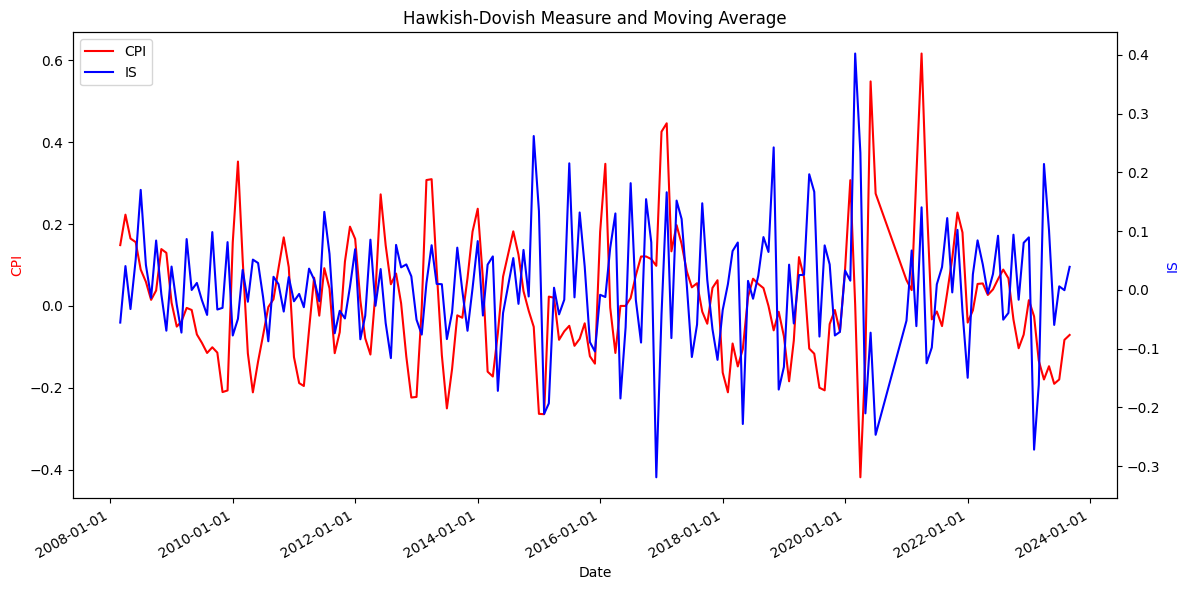

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'month' is a datetime column
#inflacion['month'] = pd.to_datetime(inflacion['month'])
#inflacion['month'] = inflacion['month'].dt.to_timestamp()

# Create a figure and two axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot CPI on the primary y-axis in red
ax1.plot(inflacion.groupby('month')['month'].mean(), 
         inflacion.groupby('month')['cpi'].mean().pct_change(2), color='red', label='CPI')

# Plot the moving average on the secondary y-axis in blue
ax2.plot(inflacion.groupby('month')['month'].mean(), 
         inflacion.groupby('month')['sent_chile'].mean().pct_change(2), color='blue', label='IS')

# Set the labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI', color='red')
ax2.set_ylabel('IS', color='blue')
plt.title('Hawkish-Dovish Measure and Moving Average')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Use a date formatter for the x-axis
date_format = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_format)

# Autoformat the date labels
fig.autofmt_xdate()

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Tighten the layout
plt.tight_layout()

# Show the plot
plt.show()

In [41]:
inflacion.groupby('time')['cpi'].mean().pct_change(2).corr(inflacion.groupby('time')['sent_score'].mean())

-0.007892096405917749

In [49]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Download the Spanish stop words from NLTK
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(stop_words=spanish_stopwords,ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(inflacion['text'])


#Splitting the data into trainig and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, inflacion['sent'], test_size=0.20, random_state=123)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Caluclating the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'an', 'as', 'bamos', 'est', 'estuvi', 'fu', 'hab', 'habr', 'hubi', 'is', 'l', 'm', 'n', 'qu', 'ramos', 's', 'semos', 'ser', 't', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.
  warnings.warn(


Accuracy Score:  0.8889337098292323


In [507]:
import os 
if not os.path.exists('../results/'):
  os.makedirs('../results/')

inflacion.to_pickle('../results/inflacion.pkl')

## Classify the `sentiment rule`

remove unnecesary sentence

In [508]:

import re

def remove_sentences_with_keywords(text, keywords):
    """
    Removes sentences that contain any of the specified keywords.

    :param text: The original text.
    :param keywords: A list of keywords to check for in each sentence.
    :return: The text with the specified sentences removed.
    """
    # Split text into sentences
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    # Filter out sentences that contain any of the keywords
    filtered_sentences = [sentence for sentence in sentences if not any(keyword in sentence for keyword in keywords)]

    # Combine the remaining sentences back into a single string
    return filtered_sentences



In [509]:
keywords = ["copyright", "derechos", 'newsletter', 'pagina', 'ciudad mexico']
inflacion['content'] = inflacion['content'].apply(lambda x: ' '.join(remove_sentences_with_keywords(x, keywords)))

now apply spanish stopwords to sentences

In [510]:
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words("spanish"))

def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in spanish_stopwords]
  return ' '.join(filtered_words)

inflacion['text'] = inflacion['text'].progress_apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 37185/37185 [00:00<00:00, 86007.06it/s]


In [511]:
inflacion[inflacion.content.str.contains('inflacion')][['text','month','cpi','tx_cpi','label']].sample(5)

,text,month,cpi,tx_cpi,label
6876,industria manufacturera europa china freno mes aunque aliviaron presiones inflacionarias estrictas medidas politica monetaria controlar inflacion ...,2011-05-01,3.25,-0.032738,positivo
31565,sector privado llamo promover formalidad empresas empleos luego presidente andres manuel lopez obrador considero conferencia matutina economia inf...,2022-10-01,8.41,-0.033333,positivo
13406,debilitamiento inversion privada incertidumbre futuro mexico hizo fondo monetario internacional fmi recortara tercera vez ano expectativa crecimie...,2018-11-01,4.72,-0.036735,positivo
22704,precio promedio gasolina unidos supero sabado dolares galon primera vez historia incluso california rebaso dolares prolonga aumento costos combust...,2022-06-01,7.99,0.044444,negativo
25957,medio debilidad dolar nivel internacional espera anuncio politica monetaria banco mexico proximo jueves peso mexicano aprecia apertura ciento tasa...,2022-08-01,8.70,0.067485,negativo


In [512]:
inflacion.loc[3979,'text']

'consumo mundial primera vez despues anos precios internacionales cafe favorables productores aumento ciento consumo mundial pais castigando caficultores restaron millones pesos dos programas fundamentales burocracia ahoga asento coordinadora nacional organizaciones cafetaleras cnoc cirilo elotlan diaz secretario general cnoc explico debido baja produccion cafe brasil colombia afectados cambio climatico augura baja oferta precios grano mercado internacional incrementado mas ciento ultimos dias comparacion mismo periodo ano anterior probable precios mantengan elevados proximos tres anos brasil reconvirtiendo amplias zonas cafetales sembradios cana azucar dar mas impulso produccion biocombustibles productores dijo esperan instalacion comision especial cafe camara diputados demandar reacomodo presupuesto dejo sector pues sigue pendiente actualizacion padron cafetalero cuya elaboracion ano pasado utilizaron recursos ignora quedo monto'

In [513]:
inflacion = inflacion[inflacion.label!='neutro']

In [514]:
#Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Download the Spanish stop words from NLTK
nltk.download('stopwords')
spanish_stopwords = stopwords.words('spanish')

token = RegexpTokenizer(r'[a-zA-Z0-9]+')

cv = CountVectorizer(stop_words=spanish_stopwords,ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(inflacion['text'])


#Splitting the data into trainig and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, inflacion['label'], test_size=0.20, random_state=123)

#Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

#Calculating the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)
print("Accuracy Score: ",accuracy_score)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierredelice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'

/Users/miniconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'an', 'as', 'bamos', 'est', 'estuvi', 'fu', 'hab', 'habr', 'hubi', 'is', 'l', 'm', 'n', 'qu', 'ramos', 's', 'semos', 'ser', 't', 'tambi', 'ten', 'tendr', 'teng', 'tuvi'] not in stop_words.



Accuracy Score:  0.7257867399938894


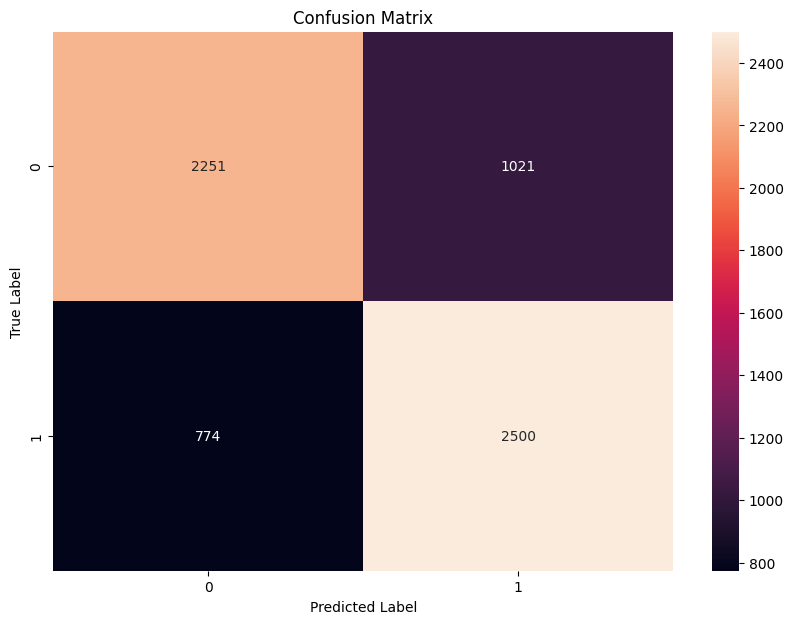

In [515]:
# Add the necessary import for confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Calculating the confusion matrix
cm = confusion_matrix(Y_test, predicted)

# Plotting the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

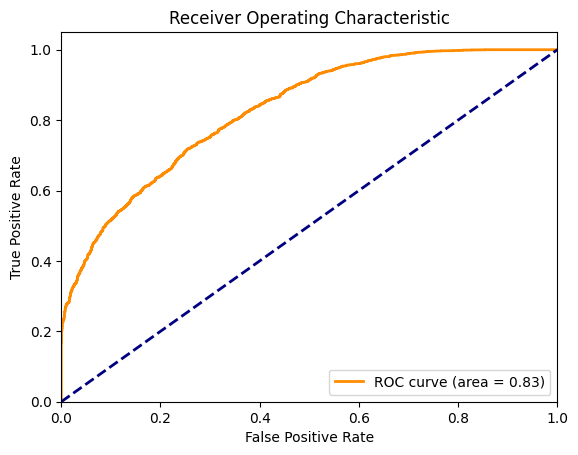

In [516]:
# Your existing imports and code here

# ...

# Import necessary libraries for ROC and AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Your existing model training code here

# ...

# Map your categorical labels to numeric values
# Assuming 'positivo' is the positive class
Y_train_num = Y_train.map({'negativo': 0, 'positivo': 1})
Y_test_num = Y_test.map({'negativo': 0, 'positivo': 1})

# Retrain your model with numeric labels
MNB.fit(X_train, Y_train_num)

# Compute predicted probabilities for the positive class
y_pred_prob = MNB.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the numeric labels
fpr, tpr, thresholds = roc_curve(Y_test_num, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [518]:
# Import necessary library for cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Since you're using a text dataset, make sure to convert your labels to numeric if they are not already
# Assuming your labels are 'negativo' and 'positivo'
Y_num = inflacion['label'].map({'negativo': 0, 'positivo': 1})

# Perform cross-validation
# Note that cross_val_score will handle the splitting of the data
scores = cross_val_score(MNB, text_counts, Y_num, cv=skf, scoring='accuracy')

# Print out the scores
print("Cross-validated scores:", scores)
print("Average score:", scores.mean())


Cross-validated scores: [0.73693859 0.73418882 0.74182707 0.74152154 0.74091048 0.72532844
 0.73632753 0.74549343 0.72860636 0.73166259]
Average score: 0.7362804848441385


In [519]:
# Import different machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Create a dictionary of models
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC(probability=True),
    'RandomForestClassifier': RandomForestClassifier()
}

# Iterate over models, train, and evaluate them
for name, model in models.items():
    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(Y_test, predictions)
    f1 = f1_score(Y_test, predictions, average='binary', pos_label='positivo')

    print(f'{name} - Accuracy: {accuracy}, F1 Score: {f1}')


MultinomialNB - Accuracy: 0.7257867399938894, F1 Score: 0.7358351729212657
LogisticRegression - Accuracy: 0.783837457989612, F1 Score: 0.7860275215484651
SVC - Accuracy: 0.7818515123739689, F1 Score: 0.7934027777777778
RandomForestClassifier - Accuracy: 0.785670638557898, F1 Score: 0.7982165971523084


## Transformer

In [225]:
# Imports
import os
import nltk
import torch
import random
import string
import datasets

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pprint import pprint
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod

from nltk.corpus import brown
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext.vocab import Vectors

# transformers library
from transformers import Trainer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification

%load_ext tensorboard

In [68]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [69]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [70]:
# Tokenize the input texts
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
  """
  Tokenises incoming sequences;

  Args:
    examples: Sequence of strings
      Sequences to tokenise

  Returns:
    Returns transformer autotokenizer object with padded, truncated input sequences.
  """
  return tokenizer(examples["text"], padding="max_length", truncation=True)

# Here we use the `DATASET` as defined above.
# Recall that DATASET = load_dataset("yelp_review_full", ignore_verifications=True)
tokenized_datasets = DATASET.map(tokenize_function, batched=True)

NameError: name 'DATASET' is not defined

In [ ]:
amen

NameError: name 'amen' is not defined

In [ ]:
#Loading the dataset
data = inflacion[['content','sent']]
#Pre-Processing the text 
def cleaning(df, stop_words):
    df['content'] = df['content'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['content'] = df['content'].str.replace('d', '')
    # Removing stop words
    df['content'] = df['content'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    #df['content'] = df['content'].apply(lambda x: ' '.join([Word(x).lemmatize() for x in x.split()]))
    return df

data_cleaned = cleaning(data, spanish_stopwords)

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_1753/1530733149.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_1753/1530733149.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/f7/cfmwg9550852tgnwq3tw36vr0000gn/T/ipykernel_1753/1530733149.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:

#Generating Embeddings using tokenizer
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_cleaned['sent'].values)
X = tokenizer.texts_to_sequences(data_cleaned['sent'].values)
X = pad_sequences(X)
#Model Building
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(704, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(352, activation='LeakyReLU'))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())
#Model Training
model.fit(X_train, y_train, epochs = 20, batch_size=32, verbose =1)
#Model Testing
model.evaluate(X_test,y_test)

NameError: name 'Tokenizer' is not defined

----
# Descripción de las variables para explicar el ``crecimiento económico``
1. Producción ($P_t$)
2. Oferta ($O_t$)
3. Exportación ($X_t$)
4. Consumo ($C_t$)
5. Demanda ($D_T$)
6. Importación ($N_t$)
7. Inversión ($I_t$)
8. Capital ($K_t$)
9. Interés ($Ti_t$)
10. Tasa cambio ($Tc_t$)
11. Moneda ($M_1$ & $M_2$)
12. Inflación ($Inf_t$)
13. Tecnología ($TIC_t$)
14. Salud ($Corona_t$)
15. Politica ($Polt$)

$$GDP_t = P_t + C_t + I_t + Ti_t + Tx_t + Inf_t+ N_t + X_t + \epsilon_t$$


## Definition of main concepts:
 

| Concepts      | Definition |
| :----------- | :----------- |
| ``Economic Status:``      | A sentence pertaining to the state of the economy, relating to ``unemployment`` and `inflation`|
| ``Dollar Value Change:``   | A sentence pertaining to changes such as appreciation or depreciation of value of the United States Dollar on the ``Foreign Exchange Market``|
|``Energy/House Prices:`` | A sentence pertaining to changes in prices of real estate, energy commodities, or energy sector as a whole.
| ``Foreign Nations:`` | A sentence pertaining to trade relations between the United States and a foreign country. If not discussing United States we label neutral.
| ``Fed Expectations/Actions/Assets:`` | A sentence that discusses changes in the Fed yields, bond value, reserves, or any other financial asset value.
| ``Money Supply:`` | A sentence that overtly discusses impact to the money supply or changes in demand.
| ``Labor:`` | A sentence that relates to changes in labor productivity

### Example of the phrases to track

| Category                        | Dovish                                                                                                                                                               | Hawkish                                                                                                                                              |
| ------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| Economic status                 | when inflation decreases, when unemployment increases, when economic growth is project low                                                                           | when inflation increases, when unemployment decreases                                                                                                |
| Dollar value change             | when dollar appreciates                                                                                                                                              | when dollar depreciates                                                                                                                              |
| Energy/House prices             | when oil/energy prices decrease                                                                                                                                      | when oil/energy prices increase                                                                                                                      |
| Foreign nations                 | when the US trade deficit decreases                                                                                                                                  | when the US trade deficit increases                                                                                                                  |
| Fed Expectations/Actions/Assets | Fed expects subpar inflation, Fed expecting disinflation, narrowing spreads of treasury bonds, decreases in treasury security yields, and reduction of bank reserves | Fed expects high inflation, widening spreads of treasury bonds, increase in treasury security yields, increase in TIPS value, increase bank reserves |
| six                             | money supply is low, M2 increases, increased demand for loans                                                                                                        | money supply is high, increased demand for goods, low demand for loans                                                                               |


In [ ]:
# Dictionary of features to check for in the sentences
features = {
    'produccion': list(set(['industria', 'manufacturera', 'produccion','bienes servicios', 
                            'servicio', 'textile', 'maiz','agricultura','oferta',
                            'obras','ingresos','igae', 'consumo bienes','consumo servicios', 
                            'bienes publicos','produccion nacional'])),
    'consumo': list(set(['ventas','compras','consumo','demanda','consumidores'])),
    'inversion': list(set(['inversion','atracción','ied','inversion directa','inversion extranjera','capital',
                           'inversiones'])),
    'tecnologia': list(set(['tecnologia','comunicacion','internet','telefono', 
                            'inteligencia artificial'])),
    'inflacion': list(set(['inflacion','precios','precio','ipc','canasta basica','canasta','inpc',
                           'presiones inflacionarias'])),
    'importacion': list(set(['importacion','importaciones'])),
    'cambio': list(set(['tasa cambio', 'peso','dolar','divisa','moneda'])),
    'financiero': list(set(['activo','financiero', 'financiera', 'valor'])),
    'interes': list(set(['tasa interes','intereses', 'deuda', 'credito','mercado cambiario'])),
    'exportacion': list(set(['exportacion','exportaciones'])),
    'crecimiento': list(set(['pib', 'producto interno bruto','producto','economia','crecimiento economico',
                             'actividad economica','crecimiento'])),
    'salud': list(set(['coronavirus', 'covid-19', 'covid19', 'pandemia', 'crisis sanitaria', 'corona',
                       'epidemia','salud'])),
    'gobierno': list(set(['presupuesto','pef','eleccion','gobierno','impuestos','recaudacion','bonos',
                          'bono','gasto publico','gasto corriente','deficit publico'])),
    'comercio': list(set(['comercio', 't-mec','tmec','comercial','balance','arrancel'])),
    'instituciones': list(set(['fed','fmi','banco mundial', 'bm','parlamento','banco','banxico'])),
    'internacional': list(set(['internacional','paises', 'eu', 'ee uu']))
}

for key, value in features.items():
    features[key] = [unidecode(word) for word in value]

In [ ]:
from more_itertools import split_after


def tokenize(texts):
    return [nltk.tokenize.word_tokenize(t) for t in texts]

def key_word_intersection(data):
    summaries = []
    for x in tokenize((data['content']
                       .str.replace('.','', regex=True)
                       .to_numpy())):
        keywords = np.concatenate(
            [np.intersect1d(x, A_i) for A_i in features.values()])

        dot_sep_sentences = np.array(list(
            split_after(x, lambda i: i == ".")), dtype=object)
        summary = []
        for i, s in enumerate(dot_sep_sentences):
            summary.append(
                [
                    dot_sep_sentences[i][j] for j, keyword in enumerate(s) if keyword in keywords
                ])
        summaries.append(
            ', '.join([' '.join(x) for x in summary if x]))

    return summaries

df['features'] = key_word_intersection(df)
df['features_n'] = df['features'].apply(lambda x: ' '.join(keyword for keyword in x.split() if keyword in features))

In [ ]:
# filter dictionary
class SentenceFilter:
    def __init__(self, data, features):
        self.data = data
        self.features = features

    def filter_sentences(self, document):
        sentences = document.split('.')
        filtered_sentences = {}
        for feature, keywords in self.features.items():
            for sentence in sentences:
                if any(keyword in sentence.lower() for keyword in keywords):
                    filtered_sentences[feature] = sentence.strip() + '.'
                    break
        return filtered_sentences

    def apply_filter(self):
        filtered_results = self.data['content'].apply(self.filter_sentences)
        filtered_df = filtered_results.progress_apply(lambda x: pd.Series(x, dtype=object))
        merged_df = self.data.merge(filtered_df, left_index=True, right_index=True, how='outer')
        return merged_df


data = SentenceFilter(df, features).apply_filter()

100%|██████████| 17556/17556 [00:02<00:00, 6988.24it/s] 


In [ ]:
data['col_na'] = 16 - data[['cambio', 'inversion', 'internacional',
       'crecimiento', 'gobierno', 'instituciones', 'interes', 'produccion',
       'comercio', 'financiero', 'importacion', 'exportacion', 'tecnologia',
       'inflacion', 'consumo', 'salud']].isna().sum(axis = 1)
data = data[data.col_na >0]

positivo1 = """aumento aumentar arriba apreciar aprecio apreciacion 
positivo encarecieron elevada impulsar repuntar repunto repunte incrementar incremento 
incrementaron confianza recuperar recuperacion expander expansion rendir rendimientos
  ascender ascenso elevo acelera acelerar crecer creciendo subieron subir subio 
  alta alza creacion crezca oportunidad ventaja ascender ascienden asciende 
  disparar dispararon subida repunte encarecer mejorar""".split()

negativo1 = """ frenar freno amenazar amenaza desacelerar desaceleracion 
bajar bajo baja debilitar debilitamiento debilidad debil depreciar depreciacion
    caer caen cayeron caida parar parada estancar estancarse estancamiento 
    marginar marginacion empobrecer pobreza descender descendio ralentizar 
    ralentiza ralentiza reducir reducieron reducio perder perdida 
    recortar recorte recortes crisis riesgos desventaja bajada devaluar 
    devaluacion deteriorar deteriora  contraer contrajo disminuyendo
    empeorar""".split()

adverbio = """mas severa ligero suficientes lentitud moderado fuerza fuerte
graves grave motor super"""

A1 = """ mercado cambiario productos inflacion bonos produccion
  dolar peso divisa moneda canasta dinero t-mec pymes inversion ied
  actividad economica igae ingreso impuesto bolsa tecnologia fintech
  crecimiento economico consumo consumidores recuperacion obras
  empleo demanda exportacion refineria ingresos acciones capital
  activos ahorro arrancel recaudacion divisas oferta demanda venta
  compras industria accionistas """.split()

A2 = ['actividad economica','crecimiento economico','deuda publica',
      'inversion directa','produccion nacional','bienes servicios',
      'consumo bienes','consumo servicios', 'bienes publicos',
      'esperanza vida','canasta basica']


B1 = """desempleo deficit precios precio inflacion pandemia covid19 covid-19
coronavirus deuda migracion migrantes importacion gasto recesion
costos sequia guerra huelga indigencia sindicato""".split()

B2 = ['tasa interes','gasto publico','deficit publico','tipo cambio',
      'presiones inflacionarias','gasto corriente', 'paro laboral']

A11 = ['inflacion','preciar','precios','precio','alimentos','petroleo','productos','servicios',
      'ipc','inpc','produccion','consumo','bienes','canasta','ventas','consumidores','costos',
      'costos',"expectativa inflación", "tasa interés", "actividad económica","empleo"]
A22 = ['aumentar','alzar','incrementar','presionar','crecer','alzar','impulsar','provocar',
      'acelerar','sobrecalentar','ariesgar','inflacionarias','afectar','crecimiento','disparar',
      'positivo']
B11 = ['inflacionarias','interes','actividad']
B22 = ['disminucion','disminuir','bajar','bajo','decremento','reducir','reduccion','caer','caida',
      'desacelera','desacelerar','variacion','limitar','negativo']
C = ["habia", "haber", "tener", "no crecia", "no lo hacían", "no lo hacían", 
     "no lo hacían", "no lo hacían", "no lo harían", " no"] 

A1 += A11
B1 += B11
B2 += B22
A2 += A22


longitud de los títulos

## Filter dictionary

## Working with `INFLATION`

In [ ]:
## Select columns
selected_columns = ['qter'] + list(data.loc[:, 'cambio':'salud'].columns)

## Subset dataframe - inflation
inflacion = data[['date','inflacion']].loc[data.loc[:, ['date','inflacion']].notna()[ 'inflacion' ]== True]
inflacion

## Dictionario de palabras en español 
Existen algunos lexicon en español que serán usados en este análisis
1. [Sentiment analysis of the spanish financial stability report](https://www.bde.es/f/webbde/SES/Secciones/Publicaciones/PublicacionesSeriadas/DocumentosTrabajo/20/Files/dt2011e.pdf)
2. [Using the Press as A Real-Time Economic Confidence Indicator](https://www.bcentral.cl/en/content/-/detalle/documento-de-trabajo-n-938)

In [ ]:
positivo = """absorbidas capaces mitiga resisten abundancia capaz mitigaban resistido bundante cómoda mitigado restablecer
acomodaticia contención mitigar restableciendo acomodaticias desendeudamiento mitigaron restablecimiento
acomodaticio dinamismo normalidad restaurar afiance dinamizador normalizado revalorizaba afianzado disfrutan normalizados 
revalorizaciones afianzamiento eficaces normalizando revalorizado afianzando eficaz normalizándose revalorizaron ágil eficiente 
normalizar revalorizarse alcista eficientes normalizó revalorizó alcistas equilibrada oportunidades revitalización
aliviadas equilibrado optimismo revitalizar aliviado excelente ordenada robusta aliviando excelentes ordenado robustas
aliviar expandió positiva robusto aliviará expansiva positivamente robustos aliviaron favorable positivas saneada
alivio favorablemente positivo saneado amortigua favorables positivos saneados amortiguación favorece progreso 
sanearon amortiguador favorecen progresos satisfactoria amortiguan favorecido propicias 
satisfactoriamente amortiguar favorecieron propicio sólida amortiguarlos fortaleciéndose reaccionado 
sólidas amortiguarse fortalecimiento reactivación solidez apoyada fortaleció reactivándose sólido asentarse 
fortaleza reafirmando solvente recuperando suavizarán atenuación fortalezas recuperación 
solventes atenuados ganancia recuperado sostenibles beneficiándose ganó recuperan suaves beneficiar holgada 
beneficiara holgadamente recuperándose superada beneficiarán holgadas recuperar sustenta beneficiarían holgado 
recuperara tranquilidad beneficiaron holgados recuperaron vigorosamente beneficiarse mejora recuperarse 
vigoroso beneficien mejorada recuperase beneficioso mejorado recuperen benigna mejoran recuperó benignas 
mejorando reequilibrando benigno mejorándose reequilibrar benignos mejorar reforzado
bienestar mejoraron reforzándolo buen mejorase reforzará buenas mejores reforzaron 
buenos mejoría reforzó calma mejorías remontado calmar mejoró renovado umento aumentar arriba apreciar 
aprecio apreciacion positivo encarecieron elevada impulsar repuntar repunto repunte incrementar incremento 
incrementaron confianza recuperar recuperacion expander expansion rendir rendimientos ascender 
ascenso elevo acelera acelerar crecer creciendo subieron subir subio alta alza creacion crezca 
oportunidad ventaja ascender ascienden asciende disparar dispararon subida repunte encarecer mejorar
  """.split()

negativo = """
abrupta complicarían deterioraban frustró peores rémora abruptas contagiadas deteriorada grave pérdida rescatadas
abrupto contagiado deterioradas gravedad perjudica rescatar abruptos contagiaron deteriorado gravemente perjudicadas resentido
abusivo contagie deteriorando graves perjudiciales resentirse acentuaban contagio deteriorándose guerra perjuicios restaron
acentuadas contagió deteriorar impactará persistencia restringiendo acusados contracción deteriorarse inadecuados persistente resurgido
adversa contracciones deteriorase incapaces persistentes resurgimiento adversas contractiva deterioro incapaz persistieron retraimiento
adverso contrae deterioró incertidumbre perturbaciones retrasa adversos contraerse difícil incertidumbres perversos retroceder
afrontan contrajo difíciles incierta pesimismo retrocedieron afrontarían contraproducentes dificulta inciertas pesimista retrocedió
agotamiento contrayendo dificultad incierto pobre retroceso agravada contrayéndose dificultada inciertos precipicio retrocesos
agravado convulso dificultades inconveniente prematura revés agravamiento costosa dificultado indefinición preocupación secuelas
agravando costosas dificultando indeseado preocupaciones sensible agravar costoso dificultándose ineficiencia preocupado serias
agravará costosos dificultar ineficiencias preocupados serio agravarían crisis dificultaría inestabilidad preocupante serios
agravó cruda dificultarían inestable preocupantes severa agudas dañar disfunción inestables presión severas
agudizado dañaría disfunciones insostenible presiona severo agudizamiento daño drástica insuficiencia presionaban sobrecalentamiento
agudizara débil drásticas insuficiente presionada sombras agudizaran débiles drásticos insuficientes presionadas súbita
agudizaron debilidad dudas intervenida presionado sufren agudizó debilidades empeora intervenidas presionados sufrida
agudo debilita empeorado intervenir presionan sufridas agudos debilitada empeoramiento invalidar presionando sufrido
altibajos debilitado empeoramientos inviabilidad presionar sufridos amenaza debilitamiento empeoran inviable presionará 
sufriendo amenazados debilitan empeorando inviables presionaría sufrieran
amenazan debilitar empeorar irregular presionaron sufrieron amenazar debilitó empeoró lamentablemente presiones sufrió
amenazas débilmente endurecido lastrada problemas sufrirán anómala decepcionante endureciéndose lastradas problemática suspensión
arrastrado decepcionantes endurecimiento lastrado problemáticas temor asimétricos decepcionaron endurecimientos lastrar quebrar temores
ataque deficiencias erosión lastre quebró tensión ataques deficiente erosionado lastró quiebra tensiona
atonía deficitaria erosionar lenta quiebras tensionaban atravesando delicada escalada lento ralentice tensionado
atraviesan depresión escándalos mal ralentiza tensionamiento bache deprimidos escasísima mala ralentización tensionando
brusca deprimirían estallar malas ralentizar tensionaron bruscas desaceleración estallido merma ralentizara tensiones
brusco desastres estancada miedo ralentizarse titubeante bruscos desconfianza estrangulamiento negativa ralentizó traumática
colapsados desencadenamiento estrangulamientos negativamente rebaja truncada
colapso desequilibrada evaporarse negativas rebajadas turbulencia complejidades desequilibrio excesivo negativo rebrote turbulencias
complejo desequilibrios excesivos negativos recaída urgencia complica desestabilizadores falta obstáculo recalentamiento virulencia
complicaciones desfavorable fatiga oscilaciones recesión volátil complicada desfavorablemente frágil padece recesivas vulnerabilidad 
complicadas desfavorables frágiles padecían recrudecían vulnerabilidades
complicado destrucción fragilidad pánicos recrudecidos vulnerable complicados destruyendo fragilidades peligro recrudecieron vulnerables
complicando desvaneciendo fragmentación peligros recrudecimiento complicar deteriora frenazo penalizado recrudeció
frenar freno amenazar amenaza desacelerar desaceleracion 
bajar bajo baja debilitar debilitamiento debilidad debil depreciar depreciacion 
caer caen cayeron caida parar parada estancar estancarse estancamiento 
marginar marginacion empobrecer pobreza descender descendio ralentizar 
ralentiza ralentiza reducir reducieron reducio perder perdida recortar recorte recortes crisis riesgos desventaja bajada devaluar 
devaluacion deteriorar deteriora  contraer contrajo disminuyendo empeorar
""".split()

positivo = [unidecode(item) for item in positivo]
negativo = [unidecode(item) for item in negativo]

any(item in positivo for item in negativo)
## Fuente: https://www.bde.es/f/webbde/SES/Secciones/Publicaciones/PublicacionesSeriadas/DocumentosTrabajo/20/Files/dt2011e.pdf

False

In [ ]:
A1 = """ produccion  dinero t-mec pymes inversion ied
      igae ingreso impuesto bolsa tecnologia fintech
      crecimiento economia consumo consumidores recuperacion obras
      empleo demanda exportacion refineria ingresos acciones capital
      activos ahorro arrancel recaudacion oferta demanda venta
      compras industria""".split()

A2 = ['actividad economica','crecimiento economico',
      'inversion directa','produccion nacional','bienes servicios',
      'consumo bienes','consumo servicios', 'bienes publicos',
      'esperanza vida','mercado cambiario']

B1 = """desempleo deficit precios precio inflacion canasta productos
      pandemia covid19 covid-19 coronavirus deuda migracion migrantes 
      importacion gasto recesion costos sequia guerra divisas
      huelga indigencia sindicato inflacionarias interes actividad """.split()

B2 = ['tasa interes','gasto publico','deficit publico','tipo cambio',
      'presiones inflacionarias','gasto corriente', 'paro laboral',
      'deuda publica','canasta basica',]

C = ["habia", "haber", "tener", "no crecia", "no lo hacían", "no lo hacían", 
     "no lo hacían", "no lo hacían", "no lo harían", " no"] 


any(item in A2 for item in B1)

False

In [ ]:
# Define the rule_model function
def rule_model(s):
    label = 0
    if (any(word in s.lower() for word in A1) and any(word in s.lower() for word in A2)) or \
            (any(word in s.lower() for word in B1) and any(word in s.lower() for word in B2)):
        label = 0
    elif (any(word in s.lower() for word in A1) and any(word in s.lower() for word in B2)) or \
            (any(word in s.lower() for word in B1) and any(word in s.lower() for word in A2)):
        label = 1
    else:
        label = 2
    if label != 2 and (any(word in s.lower() for word in C)):
        return 1 - label  # turn 0 to 1, and 1 to 0
    else:
        return label

In [ ]:
data['label'] = data['content'].progress_apply(lambda x: rule_model(x))

data = data[['content','title','date','qter','label']]

100%|██████████| 14329/14329 [00:00<00:00, 24567.81it/s]


In [ ]:
inflacion['label'] = inflacion['inflacion'].progress_apply(lambda x: rule_model(x))

100%|██████████| 2868/2868 [00:00<00:00, 30989.60it/s]


In [ ]:
data.label.value_counts()

2    13224
0      882
1      223
Name: label, dtype: int64

In [ ]:
def calculate_hawkish_dovish_measure(df_meeting_data):
    try:
        print(df_meeting_data)  # Debug: print the dataframe
        count_total_sentences = len(df_meeting_data.index)
        print("Total Sentences:", count_total_sentences)  # Debug: print total sentences
        if count_total_sentences > 0:
            # count hawkish sentences
            count_hawkish_sentences = len(df_meeting_data.loc[df_meeting_data['label'] == 1].index)
            print("Hawkish Sentences:", count_hawkish_sentences)  # Debug: print hawkish sentences

            # count dovish sentences
            count_dovish_sentences = len(df_meeting_data.loc[df_meeting_data['label'] == 0].index)
            print("Dovish Sentences:", count_dovish_sentences)  # Debug: print dovish sentences

            our_measure = (count_hawkish_sentences - count_dovish_sentences) / count_total_sentences
            print("Hawkish-Dovish Measure:", our_measure)  # Debug: print hawkish-dovish measure
        else:
            our_measure = 0
        return our_measure
    except Exception as e:
        print("Error:", e)  # Debug: print the error message
        return np.nan

# Apply the calculate_hawkish_dovish_measure function to the 'result' column and create a new 'hawkish_dovish_measure' column
inflacion['inflacion'].apply(calculate_hawkish_dovish_measure)

la finalidad actualice contribuyente pague impuestos corresponden pague mas salario si actualizaba conforme inflacion tarifas no destinaba mas recursos fisco debia expuso entrevista experta temas fiscales ey.
Error: object of type 'builtin_function_or_method' has no len()
elizabeth albarran hecho actualice tarifa impuesto renta isr respecto inflacion positivo personas fisicas pues permite pagar realmente deben pesar perciban incremento salario aseguro nora morales vicepresidenta comision fiscal confederacion camaras industriales concamin.
Error: object of type 'builtin_function_or_method' has no len()
avance precios obedecio fin periodo bajas tarifas electricas varias ciudades pais luego tradicionalmente disminuyen temporada calor.
Error: object of type 'builtin_function_or_method' has no len()
octubre indice nacional precios consumidor inpc registro incremento.
Error: object of type 'builtin_function_or_method' has no len()
indicador preferido fed medir precios permanecido bajo meta c

21135   NaN
21134   NaN
21102   NaN
21101   NaN
21091   NaN
         ..
2914    NaN
2912    NaN
2904    NaN
1105    NaN
1100    NaN
Name: inflacion, Length: 2868, dtype: float64

In [ ]:
import pandas as pd

# Assume df_meeting_data has columns 'date', 'label'

# Define the original function to calculate our_measure
def calculate_hawkish_dovish_measure(df_meeting_data):
    count_total_dates = len(df_meeting_data['date'].unique())
    
    if count_total_dates > 0:
        # count hawkish sentences
        count_hawkish_sentences = len(df_meeting_data.loc[df_meeting_data['label'] == 1])

        # count dovish sentences
        count_dovish_sentences = len(df_meeting_data.loc[df_meeting_data['label'] == 0])

        measure = (count_hawkish_sentences - count_dovish_sentences) / count_total_dates
    else:
        measure = 0
    
    return measure

# Define the function to calculate our_measure by date and add it as a new column
def calculate_hawkish_dovish_measure_by_date(df_meeting_data):
    # Calculate the measure for each group
    grouped_data = df_meeting_data.groupby('date').apply(lambda x: calculate_hawkish_dovish_measure(x)).reset_index()

    # Rename columns for clarity
    grouped_data.columns = ['date', 'our_measure']

    # Merge the original DataFrame with the new DataFrame on 'date' column
    result_df = pd.merge(df_meeting_data, grouped_data, on='date', how='left')
    
    return result_df


In [ ]:
# Calculate our_measure by date and add it as a new column in the original DataFrame
inflacion = calculate_hawkish_dovish_measure_by_date(inflacion)

In [ ]:
inflacion

,date,inflacion,label,our_measure
0,2017-10-23,la finalidad actualice contribuyente pague impuestos corresponden pague mas salario si actualizaba conforme inflacion tarifas no destinaba mas rec...,2,0.0
1,2017-10-23,elizabeth albarran hecho actualice tarifa impuesto renta isr respecto inflacion positivo personas fisicas pues permite pagar realmente deben pesar...,2,0.0
2,2017-11-09,avance precios obedecio fin periodo bajas tarifas electricas varias ciudades pais luego tradicionalmente disminuyen temporada calor.,2,0.0
3,2017-11-09,octubre indice nacional precios consumidor inpc registro incremento.,2,0.0
4,2017-11-16,indicador preferido fed medir precios permanecido bajo meta cinco anos actualmente encuentra.,2,0.0
...,...,...,...,...
2863,2023-12-06,decision fed el miercoles informe indice precios consumidor ipc mayo el martes son duda eventos mas cruciales semana.,2,0.0
2864,2023-12-06,alzas sorpresivas tasas interes australia canada asi declaraciones agresivas gobernador suizo semana pasada sugerir inflacion mas persistente pens...,2,0.0
2865,2023-12-06,afrontar tres dias clave datos inflacion unidos reunion politica monetaria reserva federal fed banco central europeo bce mercados financieros arra...,2,0.0
2866,2023-12-09,banco sostuvo proyecto presupuesto maneja politica financiamiento responsable transparente que forma general los supuestos macroeconomicos constru...,0,-1.0


In [ ]:
data[data.date == '2017-10-09']

,content,title,date,qter,label,our_measure
0,interior capital monitoring report consignan junio julio efectuaron salidas capital millones dolares.,captacion financiera foranea mexico bajara mitad,2017-10-09,2017-10,2,0.0
1,instituto finanzas internacionales iif anticipa mercado mexicano captara ano mitad inversiones extranjeras logro atraer . acuerdo estimaciones ing...,captacion financiera foranea mexico bajara mitad,2017-10-09,2017-10,2,0.0


<AxesSubplot: xlabel='date'>

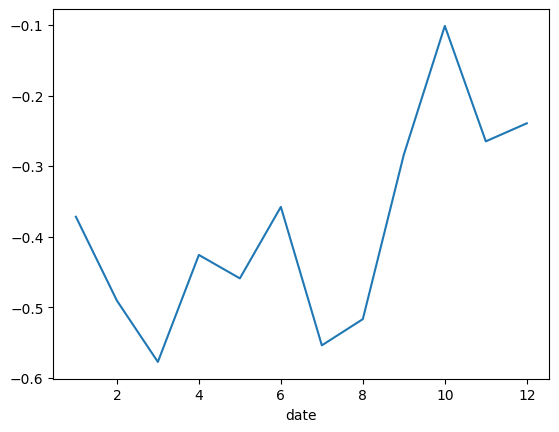

In [ ]:
inflacion.groupby(inflacion['date'].dt.month).our_measure.mean().plot()

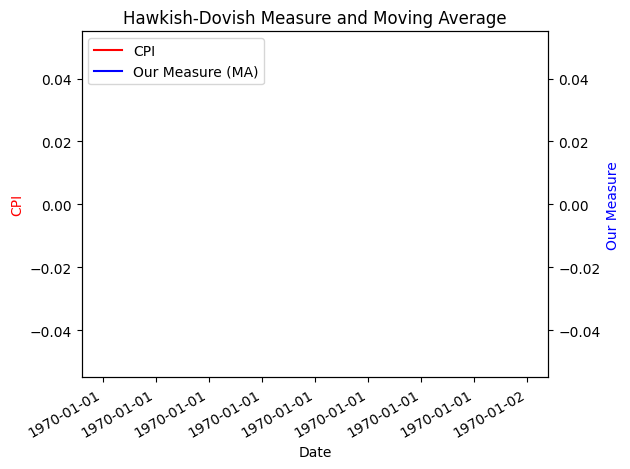

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'qter' is a datetime column
inflacion['qter'] = pd.to_datetime(inflacion['qter'])

# Calculate the 3-day moving average of our_measure
inflacion['Our_measure'] = 1 * inflacion['our_measure'].rolling(window=100).mean()

# Create a figure and two axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Plot our_measure on the primary y-axis in red
ax1.plot(inflacion['qter'], inflacion['cpi'], color='red', label='CPI')  # Update label here

# Plot the moving average on the secondary y-axis in blue
ax2.plot(inflacion['qter'], inflacion['Our_measure'], color='blue', label='Our Measure (MA)')  # Update label here

# Set the labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('CPI', color='red')
ax2.set_ylabel('Our Measure', color='blue')
plt.title('Hawkish-Dovish Measure and Moving Average')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Use a date formatter for the x-axis
date_format = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_format)

# Autoformat the date labels
fig.autofmt_xdate()

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Tighten the layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
data

,qter,cpi,content,title,date,label,our_measure,Our_measure
0,2017-10-01,6.37,interior capital monitoring report consignan junio julio efectuaron salidas capital millones dolares.,captacion financiera foranea mexico bajara mitad,2017-10-09,2,0.0,NaN
1,2017-10-01,6.37,instituto finanzas internacionales iif anticipa mercado mexicano captara ano mitad inversiones extranjeras logro atraer . acuerdo estimaciones ing...,captacion financiera foranea mexico bajara mitad,2017-10-09,2,0.0,NaN
2,2017-10-01,6.37,informe semestral monitor fiscal divulgado horas inicien reuniones organismo banco mundial destacan que economias desarrollo redistribucion fiscal...,desigualdad inevitable sistema economico mercado fmi,2017-10-11,2,-1.0,NaN
3,2017-10-01,6.37,matiza excesiva puede erosionar cohesion social conducir polarizacion politica ultima instancia reducir crecimiento economico.,desigualdad inevitable sistema economico mercado fmi,2017-10-11,0,-1.0,NaN
4,2017-10-01,6.37,yolanda morales luis miguel gonzalez washington. reconoce fondo monetario internacional fmi que sistema economico mercado desigualdad inevitable.,desigualdad inevitable sistema economico mercado fmi,2017-10-11,2,-1.0,NaN
...,...,...,...,...,...,...,...,...
14185,2023-10-01,4.26,aumento precio bitcoin arriba ciento escenografia arranque jornada martes mercados financieros operan mixtos mayor tendencia positiva.,peso cotiza . dolar tras reporte inflacion,2023-10-24,2,0.0,-0.60
14186,2023-10-01,4.26,inflacion general anual mexico . ciento primera mitad octubre hilando quincenas desaceleracion revelo indice nacional precios consumidor inpc .,inflacion hila quincenas baja . primera mitad octubre,2023-10-24,2,0.0,-0.59
14187,2023-10-01,4.26,indice nacional precios consumidor inpc mostro primera mitad octubre variacion quincenal . mientras tasa anual ubico . cerca objetivo banxico punt...,inflacion frena . primera quincena octubre acerca meta,2023-10-24,2,0.0,-0.58
14188,2023-10-01,4.26,jitomate cebolla aguacate estan registraron bajas nivel precios.,inflacion mexico productos alzas bajas precio mas pronunciadas q octubre,2023-10-24,2,0.0,-0.57


In [ ]:
# Assuming 'date' and 'cpi' are columns in your DataFrame
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(pd.to_datetime(inflacion_dt['date']), inflacion_dt['cpi'])  # Convert 'date' to datetime

# Formatting x-axis and x-ticks for date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date as 'YYYY-MM-DD'
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically choose date ticks

plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
plt.xlabel('Date')  # Set x-axis label

# Automatically adjust subplot parameters to prevent clipping of tick labels
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'date'

<Figure size 1000x600 with 0 Axes>

<AxesSubplot: >

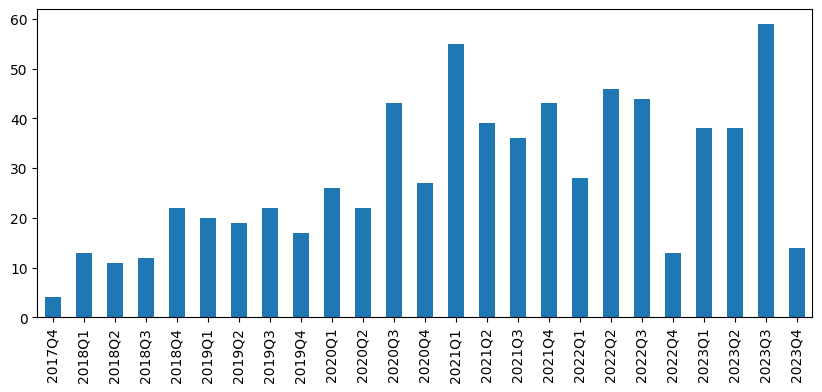

In [ ]:
#pib
data[data.content.str.contains('pib')]['qter'].value_counts().sort_index().plot(kind='bar', figsize=(10,4))

In [ ]:
data = data[~pd.isnull(data.title_pr)]

In [ ]:
specific_rows = [5,42]
pd.read_csv('Tabla.csv', encoding='utf-8',names=['col1', 'col2', 'col3', 'col4'],
            skiprows = lambda x: x in specific_rows)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 5, saw 6


# Describe topics that explain `Economic Growth`

# LDA

In [ ]:
# Tokenize the documents
processed_data = data['title_pr']

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Sample DataFrame with a column named "text"
# df = pd.DataFrame({'text': your_text_data})

# List of topics
topics = {'produccion', 'inversion', 'consumo', 'oferta', 'demanda', 'precios', 'ingreso', 'desarrollo',
          'impuestos', 'exportacion', 'importacion', 'empleo', 'desempleo', 'inflacion', 'pobreza',
          'deuda', 'dólar', 'remesas', 'migracion', 'estados unidos', 'industria', 'trabajo', 'crimen',
          'eleccion', 'recesion', 'crecimiento'}

# Convert text data to a list of strings
documents = processed_data.values.astype(str).tolist()

# Create a CountVectorizer to convert a collection of text documents to a matrix of token counts
vectorizer = CountVectorizer(vocabulary=topics)
X = vectorizer.fit_transform(documents)

# Apply LDA
num_topics = 10  # You can adjust the number of topics as per your requirement
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get topics and associated words
feature_names = vectorizer.get_feature_names_out()
topic_words = {}
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]  # Get indices of top 10 words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    topic_words[f'Topic {topic_idx + 1}'] = top_words

# Print top words for each topic
for topic, words in topic_words.items():
    print(f'{topic}: {", ".join(words)}')


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# List of topics
topics = {'produccion', 'inversion', 'consumo', 'oferta', 'demanda', 'precios', 'ingreso', 'desarrollo',
          'impuestos', 'exportacion', 'importacion', 'empleo', 'desempleo', 'inflacion', 'pobreza',
          'deuda', 'dólar', 'remesas', 'migracion', 'estados unidos', 'industria', 'trabajo', 'crimen',
          'eleccion', 'recesion', 'crecimiento'}

# Convert text data to a list of strings
documents = processed_data.values.astype(str).tolist()

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

# Number of topics
num_topics = 5

# LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get the document-topic matrix from LDA
doc_topic_matrix = lda.transform(X)

# Get the topic-word matrix from LDA
topic_word_matrix = lda.components_

# Gibbs Sampling for LDA
num_iterations = 1000
num_words = len(vectorizer.get_feature_names_out())

# Initialize the topic assignments randomly
doc_topic_assignments = np.random.choice(num_topics, size=len(documents))
word_topic_assignments = np.random.choice(num_topics, size=(len(documents), num_words))

# Gibbs sampling iterations
for iteration in range(num_iterations):
    # Update document-topic assignments
    for doc_idx in range(len(documents)):
        topic_probs = (np.sum(topic_word_matrix[:, vectorizer.transform([documents[doc_idx]]).toarray()[0] > 0], axis=1) +
                      lda.components_.sum(axis=1)) * (np.sum(doc_topic_matrix[doc_idx]) + lda.components_.sum())
        topic_probs /= np.sum(topic_probs)
        doc_topic_assignments[doc_idx] = np.random.choice(num_topics, p=topic_probs)

    # Update word-topic assignments
    for doc_idx in range(len(documents)):
        word_indices = np.where(X[doc_idx].toarray()[0] > 0)[0]
        for word_idx in word_indices:
            word_topic_probs = (topic_word_matrix[:, word_idx] + lda.components_.sum()) * \
                               (doc_topic_matrix[doc_idx] + lda.components_.sum())[doc_topic_assignments[doc_idx]]
            word_topic_probs /= np.sum(word_topic_probs)
            word_topic_assignments[doc_idx, word_idx] = np.random.choice(num_topics, p=word_topic_probs)

# Print the final topic assignments for each document
for doc_idx, topic_idx in enumerate(doc_topic_assignments):
    print(f"Document {doc_idx + 1}: Topic {topic_idx + 1}")


# Create a folder named 'data' if it does not exist
folder_path = 'data'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Iterate through each row and save it as a text file
for index, row in data.iterrows():
    # Create a unique file name based on the index or any other identifier
    file_name = os.path.join(folder_path, f'row_{index}.txt')
    
    # Open the file in write mode and save the row data as text
    with open(file_name, 'w') as f:
        # Write the row data to the file
        f.write(f'date: {row["date"]}\n')
        f.write(f'qter: {row["qter"]}\n')
        f.write(f'content: {row["sent_length"]}\n')



from transformers import pipeline

# Load the translation and summarization models
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")
summarizer = pipeline("summarization")

# Define a function to translate, summarize, and handle long texts
def translate_and_summarize(text, max_chunk_length=600, max_length=1200):
    # Check if the input text length exceeds the maximum supported length
    if len(text) > max_length:
        raise ValueError("Input text length exceeds the maximum supported length.")

    # Split the input text into chunks of max_chunk_length tokens
    chunks = [text[i:i + max_chunk_length] for i in range(0, len(text), max_chunk_length)]

    # Translate, summarize, and combine the chunks
    summaries = []
    for chunk in chunks:
        try:
            # Translate the chunk from English to Spanish
            translated_chunk = translator(chunk, src_lang="en", tgt_lang="es", max_length=max_length)[0]['translation_text']
            
            # Summarize the translated chunk
            summary = summarizer(translated_chunk, max_length=1200, min_length=600, do_sample=False)[0]['summary_text']
            summaries.append(summary)
        except Exception as e:
            print(f"Error occurred: {str(e)}")
    
    combined_summary = ' '.join(summaries)
    return combined_summary
